# Initial Steps

La ejecución del programa con 1 core sirve de base (ejecución serial) con la que comparar el resto de cores

In [21]:
!pip install psutil

In [22]:
TRIPS_PARQUET = "yellow_tripdata_2025-01.parquet"

In [23]:
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, hour, unix_timestamp, avg
from psutil import virtual_memory
from pyspark import SparkContext, SparkConf
import os
import gc
import csv

spark = SparkSession.builder.master(f"local[{1}]").getOrCreate()
#spark.conf.set('spark.cores.max', '1')
#spark.conf.set('spark.driver.memory','1000M')

sc = spark.sparkContext

spark

In [24]:
print("Number of cores available for this execution: ")
spark.sparkContext.defaultParallelism


Number of cores available for this execution: 


1

## READ DATA

To ensure a fair and consistent comparison between the serial (single-core) and Spark (parallel/distributed) implementations, the dataset is loaded before executing either version of the code.

Loading and preprocessing the dataset is not part of the computation or inference process we aim to measure. Both implementations would otherwise incur the same I/O overhead, which does not depend on the execution model. Therefore, including data loading time would make the performance evaluation inaccurate, as it would not show the actual differences in computational efficiency between the Serial and Spark APIs.

By importing, cleaning, and preparing the data only once, we guarantee that:

- Both the serial and Spark versions start from an identical, ready-to-use dataset.

- The measured execution time reflects only the computation and processing stages.

In summary, reading the Parquet file before running the two versions isolates the performance comparison to the actual data processing logic, ensuring that the evaluation focuses on the difference in computational models rather than on data I/O.

We define a helper function that uses the provided Spark session to load and filter the NYC Taxi dataset. This guarantees that each experiment (with a different core count) starts from a fresh, consistent DataFrame created under the current Spark context.

In [25]:
df_trip = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(TRIPS_PARQUET)
Initial_stadtistics = df_trip.describe()
print("Initial number of trips:", df_trip.count())
Initial_stadtistics.show()

Initial number of trips: 3475226
+-------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+-----------------+--------------------+-------------------+-------------------+
|summary|          VendorID|   passenger_count|    trip_distance|        RatecodeID|store_and_fwd_flag|     PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|     total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|
+-------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------------

## Data Filter

We have analyzed the data imported and we have discovered that there are some strange statistics that must be corrected.
In order to filter the data, outliers had to be removed, which demands metrics to be limited within logical values, such as 'trip_distance' (between 0-20 miles), or 'fare_amount' and 'total_amount (under $5000). Negative payments and extras had to be removed leading the metrics 'extra', 'tip_amount', 'tolls_amount' and so on to be restricted to values equal or greater than 0. Passenger count was limited between 1 and 6 people due to trips with 0 passengers are not logical and the sample of data with over 6 passengers is insignifcant compared to the rest.

In [26]:
df = df_trip
df = df.withColumn("trip_duration_seconds", (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")))
df = df.filter(
    (df['passenger_count'] > 0) &
    (df['passenger_count'] <= 6) &
    (df['trip_distance'] > 0) &
    (df['trip_distance'] < 200) &
    (df['fare_amount'] < 5000) & 
    (df['fare_amount'] > 0) &
    (df['extra'] >= 0) & 
    (df['mta_tax'] == 0.5) &
    (df['tip_amount'] >= 0) &
    (df['tolls_amount'] >= 0) & 
    (df['improvement_surcharge'] >= 0) &
    (df['total_amount'] > 0) &
    (df['congestion_surcharge'] >= 0) &
    (df['Airport_fee'] >= 0) &
    (df['cbd_congestion_fee'] >= 0) &
    (df['total_amount'] < 5000) &
    (df['trip_duration_seconds'] > 1)
)

print("Filtered number of trips:", df.count())

Processed_statistics = df.describe()
Processed_statistics.show()   

Filtered number of trips: 2791611
+-------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------+------------------+------------------+---------------------+------------------+--------------------+------------------+-------------------+---------------------+
|summary|           VendorID|   passenger_count|    trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|       Airport_fee| cbd_congestion_fee|trip_duration_seconds|
+-------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------+------------------+--

## Spark Session deletion

All previous cells have been done to just verify the methods and the columns of the dataset. But, in order to automate the execution of the different experiments, we are creating a funvtion that enables de deletion of the spark sessions without the need of restarting the kernel. This function is defined as follows and has been tested sucessfully.

In [27]:
def delete_spark(spark):
    try:
        spark.stop()
    except:
        pass
    try: 
        del spark
    except: 
       pass
    gc.collect()
    time.sleep(2)

We define a helper function that uses the provided Spark session to load and filter the NYC Taxi dataset. This guarantees that each experiment (with a different core count) starts from a fresh, consistent DataFrame created under the current Spark context.

In [28]:
def get_df(spark):
    df_trip = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(TRIPS_PARQUET)
    df = df_trip.withColumn("trip_duration_seconds", (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")))
    df = df.filter(
        (df['passenger_count'] > 0) &
        (df['passenger_count'] <= 6) &
        (df['trip_distance'] > 0) &
        (df['trip_distance'] < 200) &
        (df['fare_amount'] < 5000) & 
        (df['fare_amount'] > 0) &
        (df['extra'] >= 0) & ## Puede no ser por la noche
        (df['mta_tax'] == 0.5) &
        (df['tip_amount'] >= 0) & ## Si paga en cash es 0
        (df['tolls_amount'] >= 0) & #Puede no pagar tolls
        (df['improvement_surcharge'] >= 0) &
        (df['total_amount'] > 0) &
        (df['congestion_surcharge'] >= 0) &
        (df['Airport_fee'] >= 0) &
        (df['cbd_congestion_fee'] >= 0) &
        (df['total_amount'] < 5000) &
        (df['trip_duration_seconds'] > 1)
    )
    return df

# Studies

In Apache Spark, each partition corresponds to a task that can be executed in parallel. Therefore, the total number of partitions directly determines the degree of parallelism that Spark can exploit across available CPU cores.

In this assignment we want to analyze how the speedup evolves as we increase the number of cores. To observe this evolution, the workload must be parallelizable, that is, Spark needs multiple partitions that can be distributed among the available cores.

## Why we do not use `coalesce()`
In order to verify whether the workload was balanced when using RDDs, we accessed the Spark web interface at http://localhost:4040 after running the experiments.
The monitoring page showed that all tasks processed similar data sizes (around 31–33 KiB per task) and a comparable number of records (34 each), indicating that the dataset was evenly distributed across the partitions. Although slight variations were observed in the execution times (ranging from approximately 15 ms to 58 ms), these differences are minimal and can be attributed to normal fluctuations in CPU scheduling and system overhead rather than to data skew.

Overall, the results confirm that the workload was well balanced when using RDDs, with no significant performance imbalance across tasks, therefore we do not need to balance it when using RDDs.

![Task_Distr_RDD](Task_Distr.png)

## How Do We Measure the Speedup?

To evaluate Spark’s scalability, we measure the speedup obtained as we increase the number of available CPU cores. This is achieved through a series of controlled executions, each using a different number of cores under a clean Spark context.

Instead of manually restarting the Jupyter kernel between runs, we define a helper function `delete_spark(spark)` that stops and clear the active Spark session before creating a new one. This ensures that each experiment starts from a fresh Spark environment, avoiding any cached data, residual configurations, or memory references from previous executions.

For each iteration, we dynamically create a new Spark session with the desired number of cores, load the dataset, and perform the computation:

```python
delete_spark(spark)
spark = SparkSession.builder.master(f"local[{i}]") \
    .appName(f"<any_name>_{i}_cores") \
    .getOrCreate()
df = get_df(spark)



We consider this to be the optimal method for doing this project because there is no need to restart the kernel for each execution and the calcultions can be automatized. Additionally, we run all the test in the same computer by using docker. The computer has the following characteristics:

In [29]:
available_cores=os.cpu_count()
print("Number of cores available in this machine: ")
print(available_cores)


Number of cores available in this machine: 
8


In [30]:
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 3.9 gigabytes of available RAM



## Average-speed

In this section we are going to calculate the average speed (in Miles Per Hour) from the New York taxis in every hour of the day.

- First, we need to extract the **speed in mph** for each travel. This is calculated by dividing the variable *trip_distance* between the *trip_duration_seconds* (previously obtained in the preprocess done).

- Afterwards, we obtain the hour in which the beginning of the travel takes place (**pickup_hour**).

- Then, we group by hour and calculate the average for the travels in that hour (**average_speed_mph**).

### Basic functions

We are going to make our investigation between 1 and 10 cores. 
The execution with 1 core is going to be used as the baseline for calculating the speedup. This is because with just 1 core there is no parallelization and all the process is done in serial.

In [31]:
CORES_LIST = range(1, 11)
spark = None 

The results will be shown using pandas dataframes and the library matplotlib for a better visualization image.

In [32]:
def plot_avg_speed_results(pandas_df, title):
# Function for plotting average speed by hour on each method using pandas dataframe.
    if pandas_df is None or pandas_df.empty:
        print(f"No hay datos para graficar: {title}")
        return
        
    plt.figure(figsize=(12, 6))
    plt.bar(pandas_df['pickup_hour'], pandas_df['average_speed_mph'], color='dodgerblue')
    plt.xlabel('Hora del Día (0-23)')
    plt.ylabel('Velocidad Promedio (MPH)')
    plt.title(title)

    if len(pandas_df['pickup_hour']) <= 24:
        plt.xticks(pandas_df['pickup_hour'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


### Dataframes

The method `.withColumn()` is used for generating the additional columns needed for the calculations. In order to group the travels by hour we have used `.groupby()` followed by an aggregation function to calculate the average. Finally we sort the results by time with `.orderby()`.

In [33]:
def analyze_speed_dataframes(df_clean):

    dataframe_start = time.time()

    # Calculate speed and extract hour
    df_with_speed = df_clean.withColumn(
        "speed_mph",
        col("trip_distance") / (col("trip_duration_seconds") / 3600)
    )
    df_with_hour = df_with_speed.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))

    # Calculate average speed per hour
    avg_speed_per_hour = df_with_hour.groupBy("pickup_hour").agg(
        avg("speed_mph").alias("average_speed_mph")
    ).orderBy("pickup_hour")

    # Action: .collect() to get the results
    results = avg_speed_per_hour.collect()
    
    dataframe_end = time.time()
    dataframe_time = dataframe_end - dataframe_start
    
    # Convert to Pandas for consistent plotting
    pandas_df = pd.DataFrame(results, columns=['pickup_hour', 'average_speed_mph'])
    
    return pandas_df, dataframe_time


Session started with 1 cores: pyspark-shell
DataFrame time with 1 cores: 2.1531s

Session started with 2 cores: DF_SpeedAnalysis_2_cores
DataFrame time with 2 cores: 1.4318s

Session started with 3 cores: DF_SpeedAnalysis_3_cores
DataFrame time with 3 cores: 1.5819s

Session started with 4 cores: DF_SpeedAnalysis_4_cores
DataFrame time with 4 cores: 1.3959s

Session started with 5 cores: DF_SpeedAnalysis_5_cores
DataFrame time with 5 cores: 1.0696s

Session started with 6 cores: DF_SpeedAnalysis_6_cores
DataFrame time with 6 cores: 1.2219s

Session started with 7 cores: DF_SpeedAnalysis_7_cores
DataFrame time with 7 cores: 1.2400s

Session started with 8 cores: DF_SpeedAnalysis_8_cores
DataFrame time with 8 cores: 1.1188s

Session started with 9 cores: DF_SpeedAnalysis_9_cores
DataFrame time with 9 cores: 1.3706s

Session started with 10 cores: DF_SpeedAnalysis_10_cores
DataFrame time with 10 cores: 1.0196s
Plotting last DataFrame result...


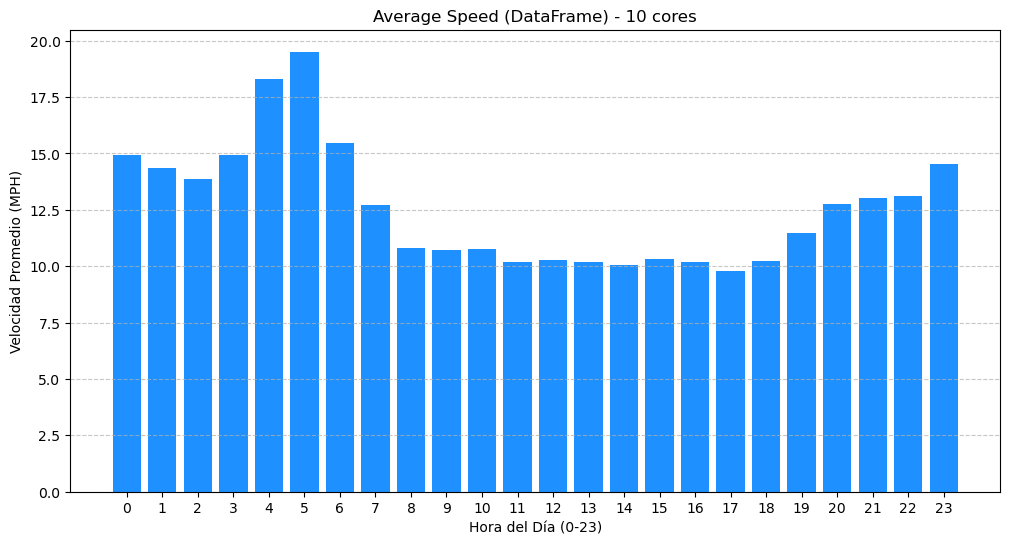

DataFrame Times: [2.1530532836914062, 1.4318454265594482, 1.581946611404419, 1.395857572555542, 1.069617509841919, 1.2218875885009766, 1.2399773597717285, 1.1187546253204346, 1.3706398010253906, 1.0195958614349365]


In [34]:
avg_speed_df_times = []

for i in CORES_LIST:
    delete_spark(spark)
    spark = SparkSession.builder.master(f"local[{i}]").appName(f"DF_SpeedAnalysis_{i}_cores").getOrCreate()
    print(f"\nSession started with {i} cores: {spark.sparkContext.appName}")
    
    df = get_df(spark)
    
    pandas_df_results, df_time = analyze_speed_dataframes(df)
    avg_speed_df_times.append(df_time)
    print(f"DataFrame time with {i} cores: {df_time:.4f}s")

# Plot of the last result
print("Plotting last DataFrame result...")
plot_avg_speed_results(pandas_df_results, f"Average Speed (DataFrame) - {i} cores")
print("DataFrame Times:", avg_speed_df_times)

### RDDs

- First, we apply the `.map()` transformation for all the rows from the rdd and apply the function **calculate_speed**. We obtain a new rdd with key-value tupples (pickup_hour, speed).

- Then, we `reduceByKey()` all the tupples sharing the key pickup_hour and we reduce the rdd to 24 elements (24 hours) with the total number of travels and the total speed for each our.

- Finally, we calculate the average speed using `.mapValues()`, we order the results by hour with `.sortByKey()` and we make the action call with `.collect` to execute all the program.

In [35]:
def analyze_speed_rdds(df_clean):
# For RDDs the calculation is divided into 2 functions
    rdss_start = time.time()

    # RDD auxiliary function for calculating speed and hour
    def calculate_speed(row):
        try:
            pickup_time = row['tpep_pickup_datetime']
            dropoff_time = row['tpep_dropoff_datetime']
            distance = float(row['trip_distance'])
            
            # The RDD needs datetime objects for this subtraction
            duration_seconds = (dropoff_time - pickup_time).total_seconds() 
            
            # These filters are already in get_df, but we keep them
            # just in case and to follow the original logic
            if duration_seconds <= 0 or distance <= 0:
                return None
            
            speed_mph = distance / (duration_seconds / 3600)
            pickup_hour = pickup_time.hour
            return (pickup_hour, (speed_mph, 1))
        except (TypeError, ValueError, AttributeError):
            # Catches errors if timestamps are not datetimes
            return None

    speed_rdd = df_clean.rdd.map(calculate_speed).filter(lambda x: x is not None)
    
    sum_speed_and_count_rdd = speed_rdd.reduceByKey(
        lambda x, y: (x[0] + y[0], x[1] + y[1])
    )
    
    avg_speed_rdd = sum_speed_and_count_rdd.mapValues(
        lambda total: total[0] / total[1]
    )

    # Action: .collect()
    sorted_results = avg_speed_rdd.sortByKey().collect()
    
    rdds_end = time.time()
    rdd_time = rdds_end - rdss_start
    
    # Convert to Pandas for consistent plotting
    pandas_df = pd.DataFrame(sorted_results, columns=['pickup_hour', 'average_speed_mph'])
    
    return pandas_df, rdd_time


Session started with 1 cores: RDD_SpeedAnalysis_1_cores
RDD time with 1 cores: 21.3400s

Session started with 2 cores: RDD_SpeedAnalysis_2_cores
RDD time with 2 cores: 19.2323s

Session started with 3 cores: RDD_SpeedAnalysis_3_cores
RDD time with 3 cores: 14.7658s

Session started with 4 cores: RDD_SpeedAnalysis_4_cores
RDD time with 4 cores: 13.3722s

Session started with 5 cores: RDD_SpeedAnalysis_5_cores
RDD time with 5 cores: 13.8922s

Session started with 6 cores: RDD_SpeedAnalysis_6_cores
RDD time with 6 cores: 14.2506s

Session started with 7 cores: RDD_SpeedAnalysis_7_cores
RDD time with 7 cores: 13.6526s

Session started with 8 cores: RDD_SpeedAnalysis_8_cores
RDD time with 8 cores: 17.3308s

Session started with 9 cores: RDD_SpeedAnalysis_9_cores
RDD time with 9 cores: 14.5324s

Session started with 10 cores: RDD_SpeedAnalysis_10_cores
RDD time with 10 cores: 14.2318s
Plotting last RDD result...


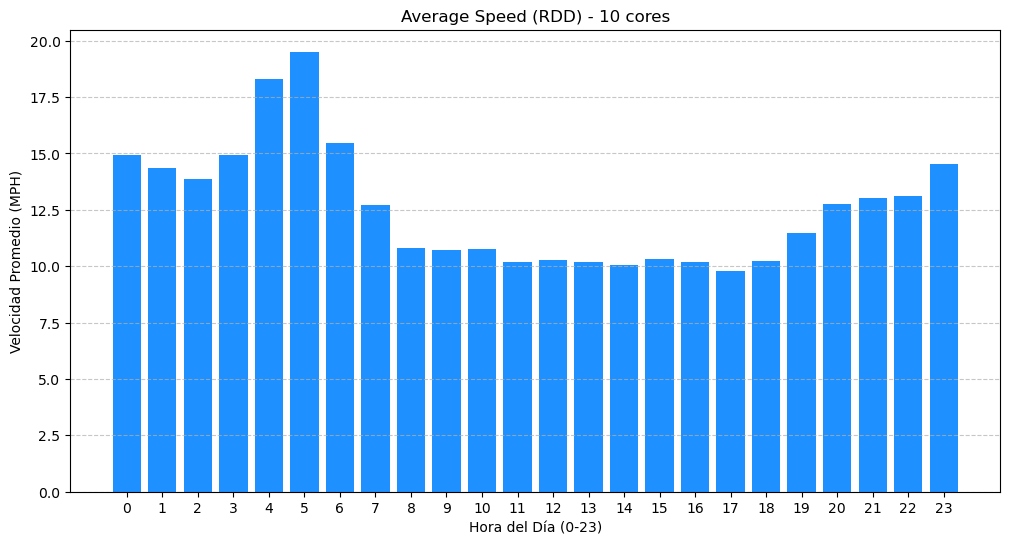

RDD Times: [21.339975357055664, 19.232285261154175, 14.765753746032715, 13.37224006652832, 13.892248153686523, 14.250586986541748, 13.652593612670898, 17.33077836036682, 14.532383680343628, 14.23175597190857]


In [36]:
avg_speed_rdd_times = []

for i in CORES_LIST:
    delete_spark(spark)
    spark = SparkSession.builder.master(f"local[{i}]").appName(f"RDD_SpeedAnalysis_{i}_cores").getOrCreate()
    print(f"\nSession started with {i} cores: {spark.sparkContext.appName}")
    
    df = get_df(spark)
    
    pandas_rdd_results, rdd_time = analyze_speed_rdds(df)
    avg_speed_rdd_times.append(rdd_time)
    print(f"RDD time with {i} cores: {rdd_time:.4f}s")

# Plot of the last result
print("Plotting last RDD result...")
plot_avg_speed_results(pandas_rdd_results, f"Average Speed (RDD) - {i} cores")
print("RDD Times:", avg_speed_rdd_times)

### SQL

In the last method, we implement SQL with a simple query that makes all the calculations and selections. The method uses a Temporal table View for making the selections and afterwards `.collect()` executes the query.

In [37]:
def analyze_speed_sql(df_clean, spark_session):
    """
    Calculates the average speed per hour using Spark SQL.
    """
    sql_start = time.time()
    
    df_clean.createOrReplaceTempView('taxis_speed_view')
    
    results_df = spark_session.sql(f"""
        SELECT
            hour(tpep_pickup_datetime) AS pickup_hour,
            AVG(trip_distance / (trip_duration_seconds / 3600.0)) AS average_speed_mph
        FROM
            taxis_speed_view
        GROUP BY
            pickup_hour
        ORDER BY
            pickup_hour
    """)
    
    # Action: .collect()
    top_rows = results_df.collect()
    
    sql_end = time.time()
    sql_time = sql_end - sql_start
    
    # Convert to Pandas for consistent plotting
    pandas_df = pd.DataFrame(top_rows, columns=['pickup_hour', 'average_speed_mph'])
    
    return pandas_df, sql_time


Session started with 1 cores: SQL_SpeedAnalysis_1_cores
SQL time with 1 cores: 2.5032s

Session started with 2 cores: SQL_SpeedAnalysis_2_cores
SQL time with 2 cores: 1.9267s

Session started with 3 cores: SQL_SpeedAnalysis_3_cores
SQL time with 3 cores: 1.3655s

Session started with 4 cores: SQL_SpeedAnalysis_4_cores
SQL time with 4 cores: 1.3462s

Session started with 5 cores: SQL_SpeedAnalysis_5_cores
SQL time with 5 cores: 1.4196s

Session started with 6 cores: SQL_SpeedAnalysis_6_cores
SQL time with 6 cores: 1.4221s

Session started with 7 cores: SQL_SpeedAnalysis_7_cores
SQL time with 7 cores: 1.3395s

Session started with 8 cores: SQL_SpeedAnalysis_8_cores
SQL time with 8 cores: 1.3115s

Session started with 9 cores: SQL_SpeedAnalysis_9_cores
SQL time with 9 cores: 1.5702s

Session started with 10 cores: SQL_SpeedAnalysis_10_cores
SQL time with 10 cores: 1.3674s
Plotting last SQL result...


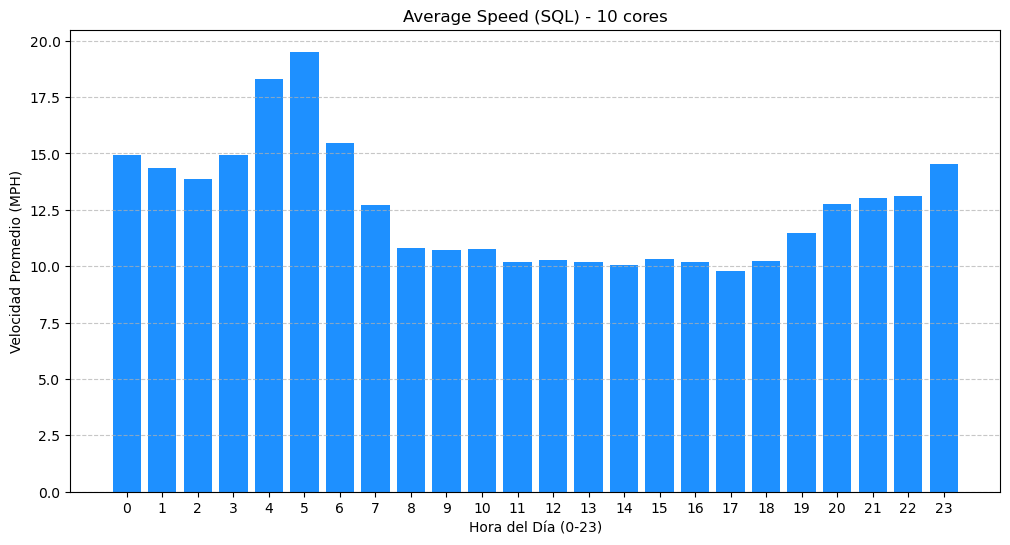

SQL Times: [2.503230571746826, 1.9266571998596191, 1.3654592037200928, 1.3462305068969727, 1.4196302890777588, 1.4220569133758545, 1.3394622802734375, 1.3114831447601318, 1.5702061653137207, 1.3674063682556152]


In [38]:
avg_speed_sql_times = []

for i in CORES_LIST:
    delete_spark(spark)
    spark = SparkSession.builder.master(f"local[{i}]").appName(f"SQL_SpeedAnalysis_{i}_cores").getOrCreate()
    print(f"\nSession started with {i} cores: {spark.sparkContext.appName}")
    
    df = get_df(spark)
    
    pandas_sql_results, sql_time = analyze_speed_sql(df, spark)
    avg_speed_sql_times.append(sql_time)
    print(f"SQL time with {i} cores: {sql_time:.4f}s")

# Plot of the last result
print("Plotting last SQL result...")
plot_avg_speed_results(pandas_sql_results, f"Average Speed (SQL) - {i} cores")
print("SQL Times:", avg_speed_sql_times)

### Speedups


--- Calculating and Plotting Speedup ---


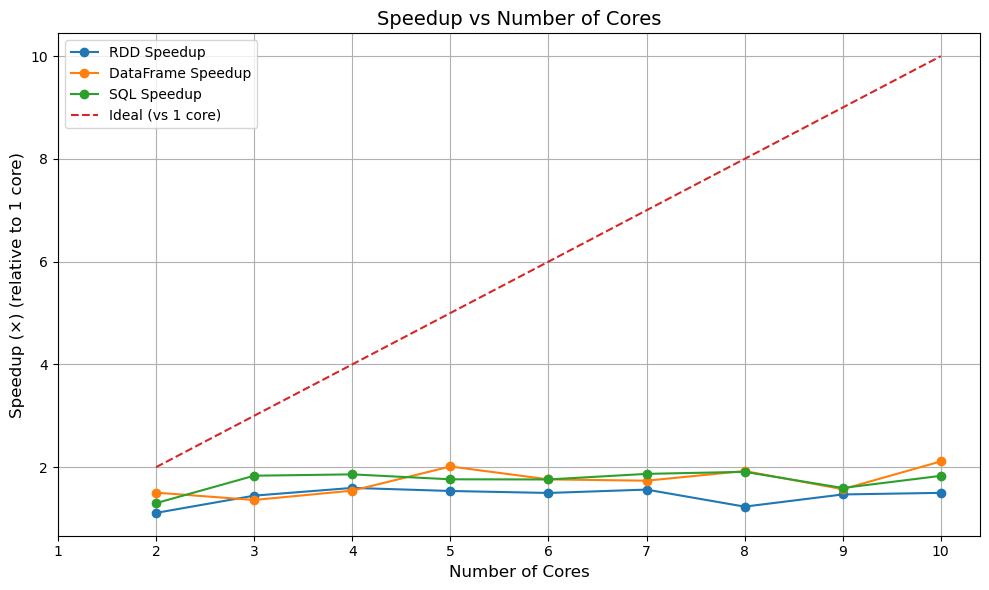


Analysis completed.


In [39]:
# --- Speedup Calculation and Plot ---
print("\n" + "="*30)
print("--- Calculating and Plotting Speedup ---")
print("="*30)

# Ensure the lists are not empty and we have at least 2 points
if not all([avg_speed_rdd_times, avg_speed_df_times, avg_speed_sql_times]) or len(CORES_LIST) < 2:
    print("Error: Not enough data to calculate speedup.")
    print("Make sure CORES_LIST has at least 2 values (e.g., [1, 2]).")
else:
    # The first time (with CORES_LIST[0] cores) is the baseline
    baseline_time_rdd = avg_speed_rdd_times[0]
    baseline_time_df = avg_speed_df_times[0]
    baseline_time_sql = avg_speed_sql_times[0]

    # The remaining times are used to calculate the speedup
    rdd_speedup1 = [baseline_time_rdd / t for t in avg_speed_rdd_times[1:]]
    dataframe_speedup1 = [baseline_time_df / t for t in avg_speed_df_times[1:]]
    sql_speedup1 = [baseline_time_sql / t for t in avg_speed_sql_times[1:]]

    # X-axis for the speedup plot (cores excluding the baseline)
    cores_speedup_axis = CORES_LIST[1:]
    
    # Ideal (linear) speedup
    baseline_core_count = CORES_LIST[0]
    ideal_speedup = [c / baseline_core_count for c in cores_speedup_axis]

    plt.figure(figsize=(10, 6))
    plt.plot(cores_speedup_axis, rdd_speedup1, marker='o', label='RDD Speedup')
    plt.plot(cores_speedup_axis, dataframe_speedup1, marker='o', label='DataFrame Speedup')
    plt.plot(cores_speedup_axis, sql_speedup1, marker='o', label='SQL Speedup')
    plt.plot(cores_speedup_axis, ideal_speedup, linestyle='--', label=f'Ideal (vs {baseline_core_count} core)')

    plt.title("Speedup vs Number of Cores", fontsize=14)
    plt.xlabel("Number of Cores", fontsize=12)
    plt.ylabel(f"Speedup (×) (relative to {baseline_core_count} core)", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.xticks(CORES_LIST)  # Show all core ticks
    plt.tight_layout()
    plt.show()

# Final cleanup
delete_spark(spark)
print("\nAnalysis completed.")


## Financial-records

### Routes with highest average costs 
The primary objective of this analysis is to study the financial records for different taxi routes in New York City by examining key financial indicators.
To achieve this, we utilize the following columns from the dataset:
- PULocationID: The taxi pickup location.
- DOLocationID: The taxi drop-off location.
- fare_amount: The base fare charged for the trip, in USD.
- tip_amount: The tip given by the passenger, in USD.
- total_amount: The total charge for the trip (fare + tip + other costs), in USD.

Each trip is grouped by its unique (PULocationID, DOLocationID) pair, forming a specific route. For each route, we compute three aggregate metrics:
- Average fare amount per route.
- Average tip amount per route.
- Average total amount per route.

By ranking the routes based on these averages, we can pinpoint which routes consistently generate the highest revenue, the best tips, and the highest overall totals, providing valuable insights for taxi drivers and fleet operators.

#### Basic Functions
Here basic functions for mapping location IDs to names and plotting the results are defined

In [40]:
# Load taxi zone lookup data, used for mapping location IDs to names
ID_TO_NAME = {}
with open('taxi_zone_lookup.csv', newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        loc = row["LocationID"].strip()
        borough = row["Borough"].strip()
        zone = row["Zone"].strip()
        ID_TO_NAME[loc] = f"{borough} – {zone}"

# Plotting function
def plot_results(labels, values, title):
    plt.figure(figsize=(12, 6))
    plt.barh(labels, values, color='skyblue')
    plt.gca().invert_yaxis()
    plt.xlabel("Average amount ($)")
    plt.ylabel("Route (Pickup → Dropoff)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

cores_range = range(1, 11)

#### DataFrames
For each core count, the following is done:
- Reconfigure Spark with current cores and start timing execution
- Aggregate data by route and metrics averages are calculated
- Find the top routes for each metric
- Store results and execution time

[5.986699342727661, 3.8363795280456543, 3.1284916400909424, 2.480149745941162, 2.2330377101898193, 2.172910451889038, 2.157130718231201, 3.0737369060516357, 2.202194929122925, 2.528144121170044]


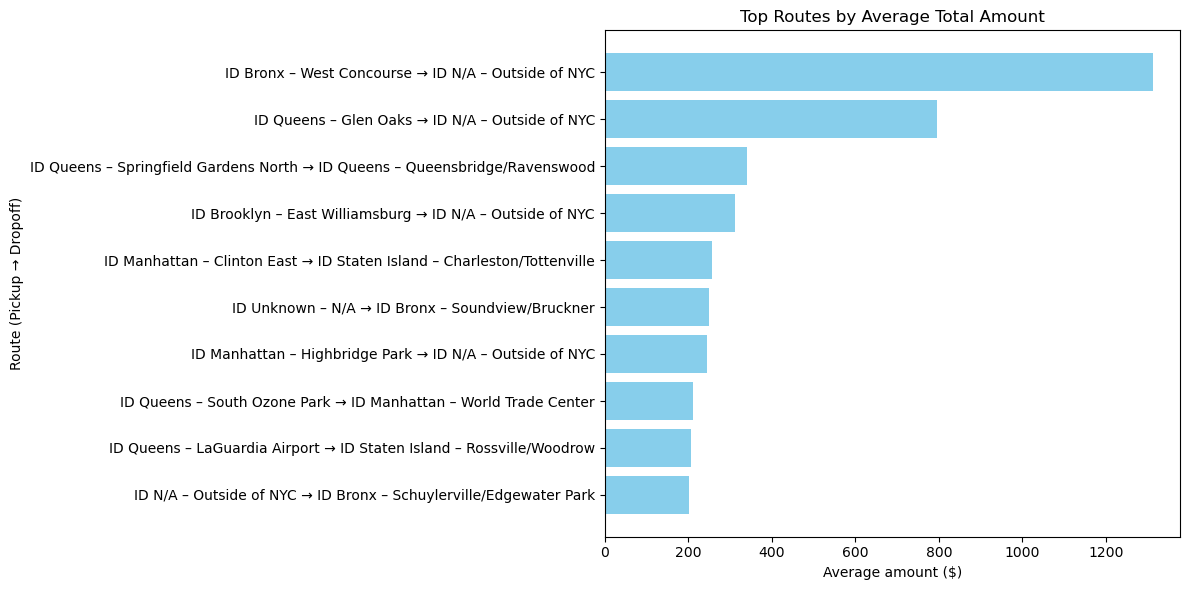

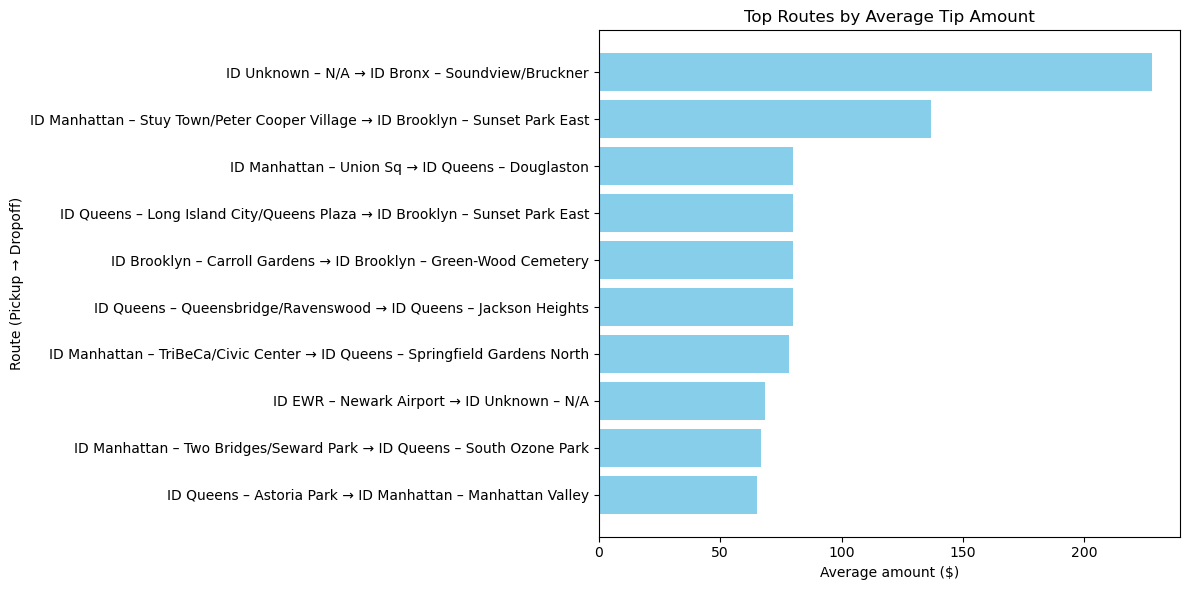

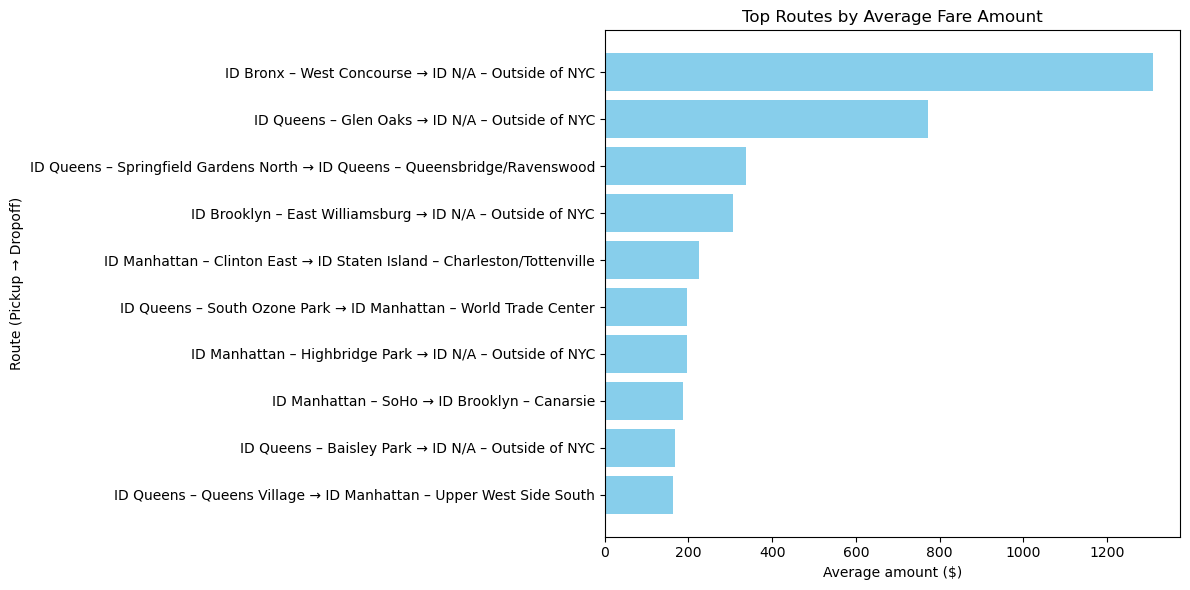

In [41]:
def get_top_routes(df, metric, n=10):
    """
    Gets the top n routes based on the specified metric.
    """
    pdf = (
        df.select("PULocationID", "DOLocationID", metric)
        .orderBy(F.desc(metric))
        .limit(n)
        .toPandas()
    )
    pdf["PULocationID"] = pdf["PULocationID"].astype(str).map(ID_TO_NAME).fillna(pdf["PULocationID"])
    pdf["DOLocationID"] = pdf["DOLocationID"].astype(str).map(ID_TO_NAME).fillna(pdf["DOLocationID"])
    pdf["route"] = pdf["PULocationID"] + " → " + pdf["DOLocationID"] # Create a route label
    return pdf

times_df = []
data_graphs = []

for num_cores in cores_range:
    # Restart Spark session with specified number of cores
    delete_spark(spark)
    spark = SparkSession.builder.master(f"local[{num_cores}]").appName(f"TaxiTrips_{num_cores}_cores").getOrCreate()
    df = get_df(spark)
    start_time = time.time()
    
    df_route = (
        df.groupBy("PULocationID", "DOLocationID")
        .agg(
            # Average matrics calculation
            F.avg("fare_amount").alias("avg_fare"),
            F.avg("tip_amount").alias("avg_tip"),
            F.avg("total_amount").alias("avg_total"),
            F.count("*").alias("count")
        )
        .cache()
    )
    # Top routes for the different metrics
    for metric, title in [
    ("avg_total", "Top Routes by Average Total Amount"),
    ("avg_tip", "Top Routes by Average Tip Amount"),
    ("avg_fare", "Top Routes by Average Fare Amount"),
]:
        top_df = get_top_routes(df_route, metric, 10)
        labels = [
            f"{ID_TO_NAME.get(str(r.PULocationID), f'ID {r.PULocationID}')} → "
            f"{ID_TO_NAME.get(str(r.DOLocationID), f'ID {r.DOLocationID}')}"
            for r in top_df.itertuples()
        ]
        values = list(top_df[metric])
        if num_cores == cores_range[-1]:
            data_graphs.append((labels, values, title))
    times_df.append(time.time() - start_time) # Collect time taken for each core count
print(times_df)

for labels, values, title in data_graphs:
    plot_results(labels, values, title)

#### RDDs
For each core count the following is done:
- Reconfigure Spark with current cores and start timing
- Transform data to RDD format with route keys and metric tuples
- Aggregate using RDD operations: 
  - reduceByKey for sums 
  - mapValues for averages
- Find top routes for each metric using sorting and filtering
- Store results and execution time

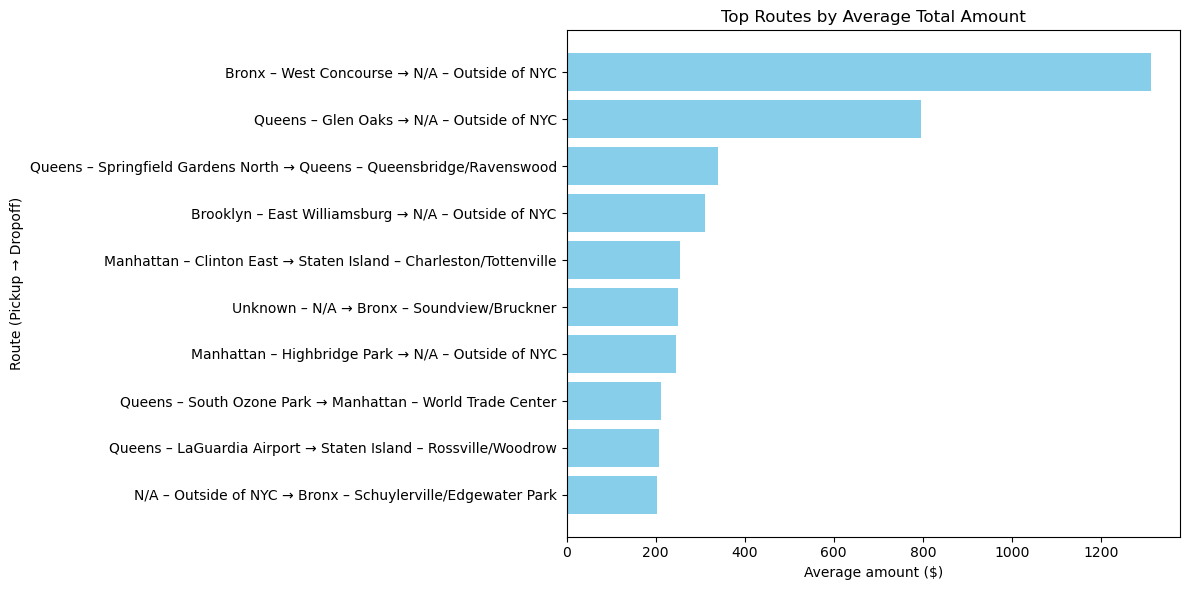

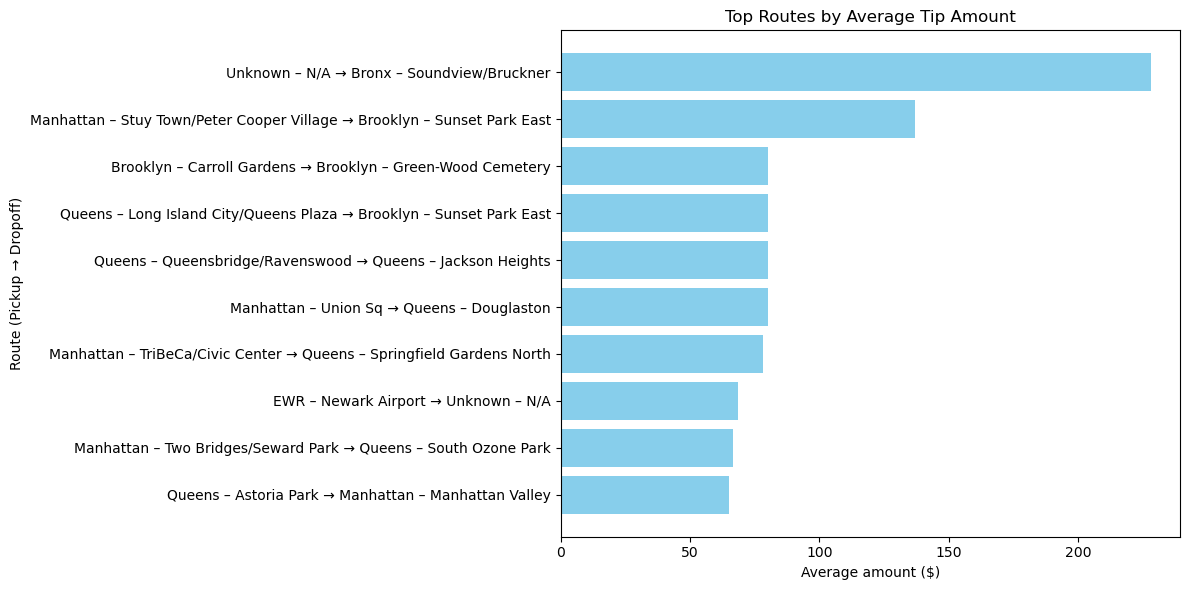

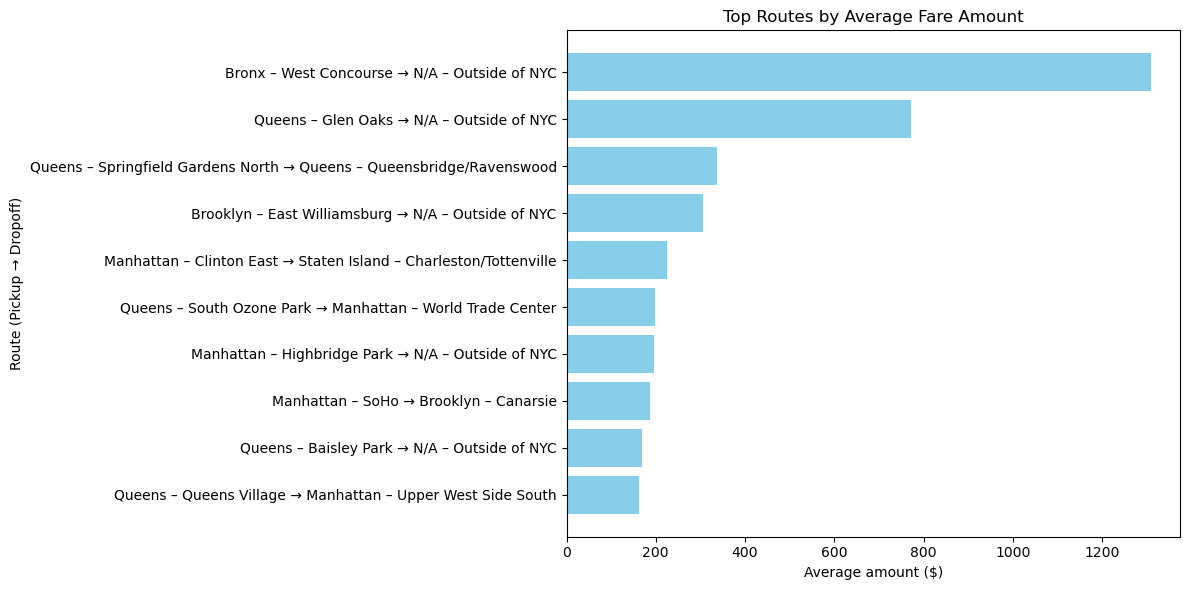

Execution times per core: [25.290693044662476, 20.711552619934082, 18.43110942840576, 18.343838691711426, 16.437126398086548, 16.35038733482361, 16.890156269073486, 16.627955198287964, 17.16323733329773, 16.453349351882935]


In [42]:
times_rdd = []
data_graphs = []
results = []

def get_top_routes(rdd, metric_index, n=10):
    """
    Gets the top n routes based on the specified metric index using RDD operations.
    """
    top = rdd.sortBy(lambda x: x[1][metric_index], ascending=False).take(n)
    results = []
    for (pu, do), metrics in top: 
        pu_name = ID_TO_NAME.get(str(pu), str(pu)) # Map ID to name, default to ID if not found
        do_name = ID_TO_NAME.get(str(do), str(do)) # Map ID to name, default to ID if not found
        # Create route string and extract metric value
        route_str = f"{pu_name} → {do_name}" 
        value = metrics[metric_index]
        results.append((route_str, value))

    return results

for num_cores in cores_range:
    delete_spark(spark)
    spark = SparkSession.builder.master(f"local[{num_cores}]").appName(f"TaxiTrips_RDD_{num_cores}_cores").getOrCreate()
    df = get_df(spark)

    start_time = time.time()
    # Transform DataFrame to RDD with route as key and metrics as values
    route_rdd = df.rdd.map(lambda row: (
        (row.PULocationID, row.DOLocationID),
        (row.fare_amount, row.tip_amount, row.total_amount, 1)
    ))
    # Aggregate metrics by route using reduceByKey
    sum_counts_rdd = route_rdd.reduceByKey(lambda a, b: (
        a[0] + b[0], # Sum fare_amount
        a[1] + b[1], # Sum tip_amount
        a[2] + b[2], # Sum total_amount
        a[3] + b[3] # Count
    ))
    # Calculate averages by dividing sums by count
    avg_rdd = sum_counts_rdd.mapValues(lambda x: (
        x[0] / x[3], # Average fare_amount
        x[1] / x[3], # Average tip_amount
        x[2] / x[3], # Average total_amount
        x[3] # Count
    ))

    metrics_info = [
        (2, "Top Routes by Average Total Amount"),
        (1, "Top Routes by Average Tip Amount"),
        (0, "Top Routes by Average Fare Amount")
    ]
    # Analyze top routes for each metric
    for metric_index, title in metrics_info:
        top_routes = get_top_routes(avg_rdd, metric_index, 10)

        if num_cores == cores_range[-1]:  # Only save results for last core configuration
            labels = [label for label, _ in top_routes]
            values = [value for _, value in top_routes]
            results.append((title, list(zip(labels, values))))
            data_graphs.append((labels, values, title))

    times_rdd.append(time.time() - start_time) # Collect time taken for each core count



# Plot the graphs
for labels, values, title in data_graphs:
    plot_results(labels, values, title)

print("Execution times per core:", times_rdd)


#### SQL
For each core count the following is done:
- Reconfigure Spark with current cores and start timing
- Register DataFrame as SQL table using temporary view
- Aggregate using SQL operations:
    - GROUP BY for route grouping
    - AVG() and COUNT() for metric calculations
- Find top routes for each metric using DataFrame sorting and limiting
- Process results by converting to Pandas and formatting route names
- Store results and execution time

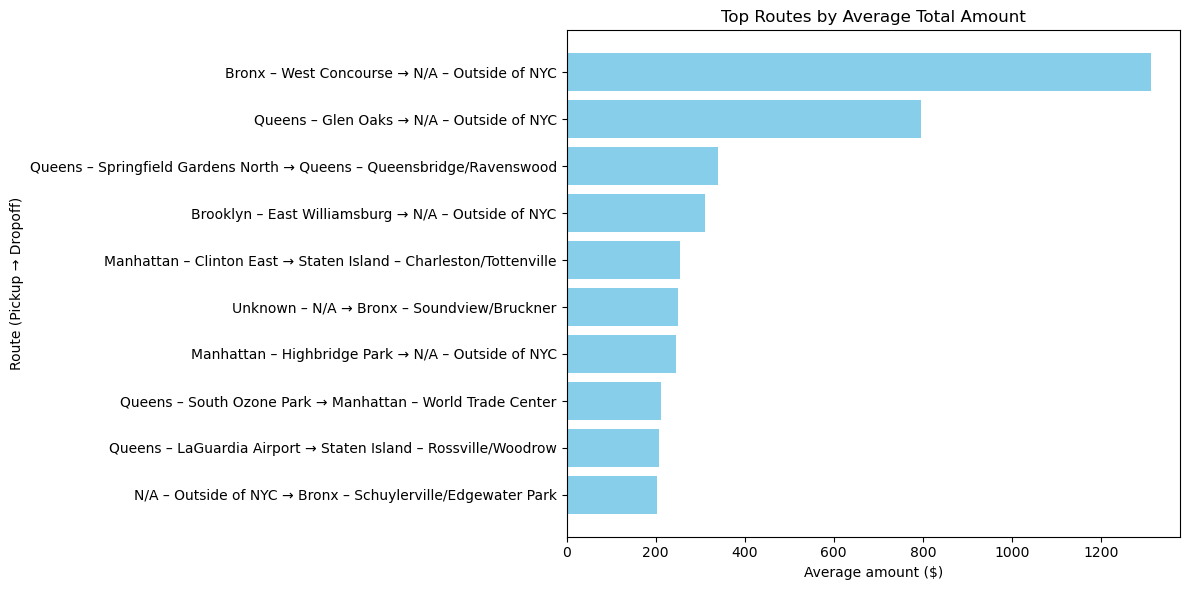

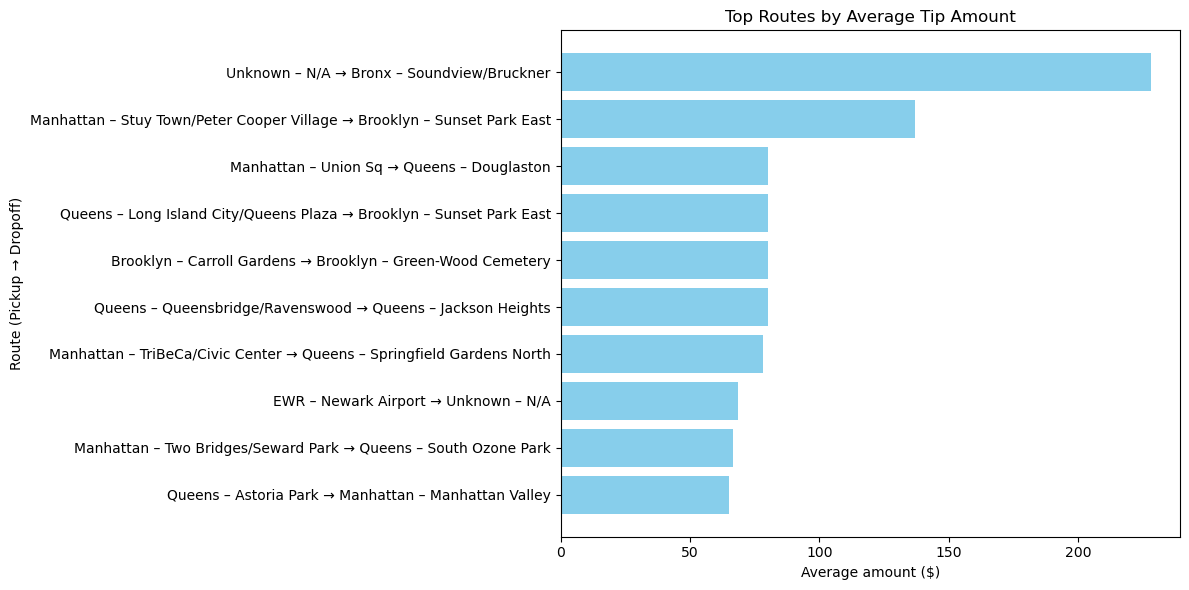

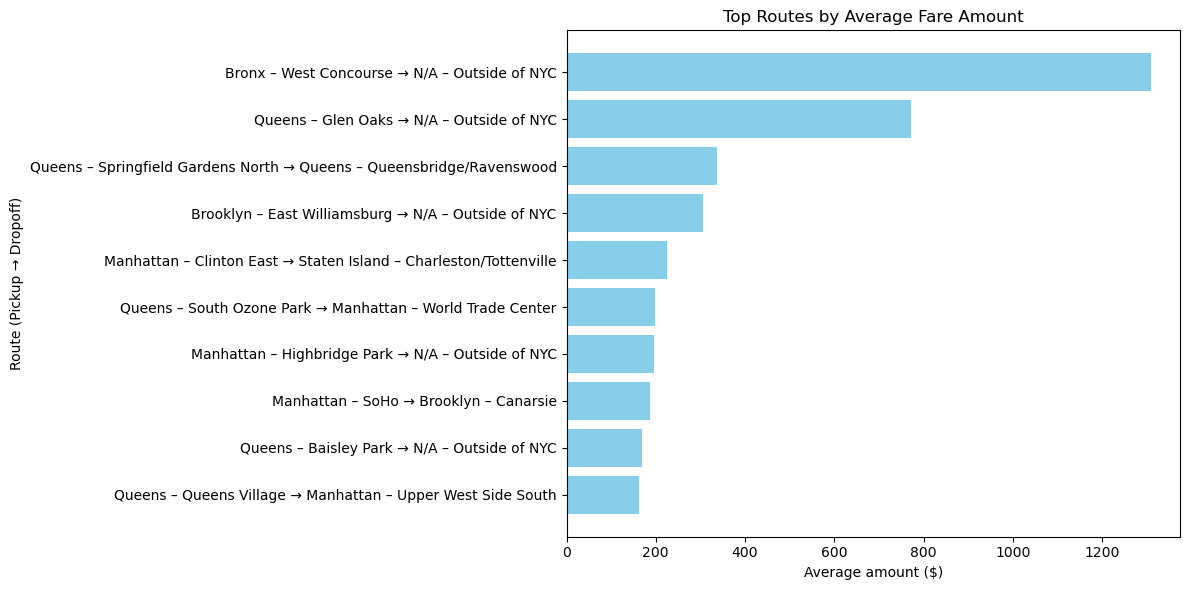

SQL Execution times per core: [5.172638416290283, 3.249558448791504, 2.4698526859283447, 2.466815948486328, 2.4187510013580322, 3.410775661468506, 2.273345947265625, 2.0090391635894775, 1.8635964393615723, 2.292386531829834]


In [43]:
times_sql = []
results = []
data_graphs = []

def get_top_routes(df, metric, n=10):
    """
    Extract top N routes using DataFrame operations, converting to Pandas for final processing and route formatting.
    """
    pdf = (
        df.select("PULocationID", "DOLocationID", metric)
        .orderBy(F.desc(metric))
        .limit(n)
        .toPandas()
    )
    # Convert ID_TO_NAME dictionary keys to strings for consistent mapping
    ID_TO_NAME_str = {str(k): v for k, v in ID_TO_NAME.items()}
    pdf["PULocationID"] = pdf["PULocationID"].astype(str).map(ID_TO_NAME_str).fillna(pdf["PULocationID"])
    pdf["DOLocationID"] = pdf["DOLocationID"].astype(str).map(ID_TO_NAME_str).fillna(pdf["DOLocationID"])
    pdf["route"] = pdf["PULocationID"].astype(str) + " → " + pdf["DOLocationID"].astype(str) # Create a route label
    return pdf

for num_cores in cores_range:
    # Restart Spark session with specified number of cores
    delete_spark(spark)
    spark = SparkSession.builder.master(f"local[{num_cores}]").appName(f"TaxiTrips_SQL_{num_cores}_cores").getOrCreate()
    df = get_df(spark)
    # Create temporary view for SQL queries
    df.createOrReplaceTempView("taxi_trips")
    start_time = time.time()
    # SQL aggregation 
    df_route = spark.sql("""
        SELECT 
            PULocationID,
            DOLocationID,
            AVG(fare_amount) as avg_fare,
            AVG(tip_amount) as avg_tip,
            AVG(total_amount) as avg_total,
            COUNT(*) as count
        FROM taxi_trips
        GROUP BY PULocationID, DOLocationID
    """).cache()
    # Top routes for the different metrics
    for metric, title in [
        ("avg_total", "Top Routes by Average Total Amount"),
        ("avg_tip", "Top Routes by Average Tip Amount"),
        ("avg_fare", "Top Routes by Average Fare Amount"),
    ]:
        top_df = get_top_routes(df_route, metric, 10)
        ID_TO_NAME_str = {str(k): v for k, v in ID_TO_NAME.items()}
        top_df["PULocationID"] = top_df["PULocationID"].astype(str).map(ID_TO_NAME_str).fillna(top_df["PULocationID"])
        top_df["DOLocationID"] = top_df["DOLocationID"].astype(str).map(ID_TO_NAME_str).fillna(top_df["DOLocationID"])
        top_df["route"] = top_df["PULocationID"].astype(str) + " → " + top_df["DOLocationID"].astype(str)

        if num_cores == cores_range[-1]:
            labels = top_df["route"].tolist()
            values = top_df[metric].tolist()
            results.append((title, list(zip(labels, values))))
            data_graphs.append((labels, values, title))

    times_sql.append(time.time() - start_time) # Collect time taken for each core count
for labels, values, title in data_graphs:
    plot_results(labels, values, title)
print("SQL Execution times per core:", times_sql)

#### Speedups
Lastly, the speedups for each method is calculated, comparing the execution for each core count to the first one (core count = 1).

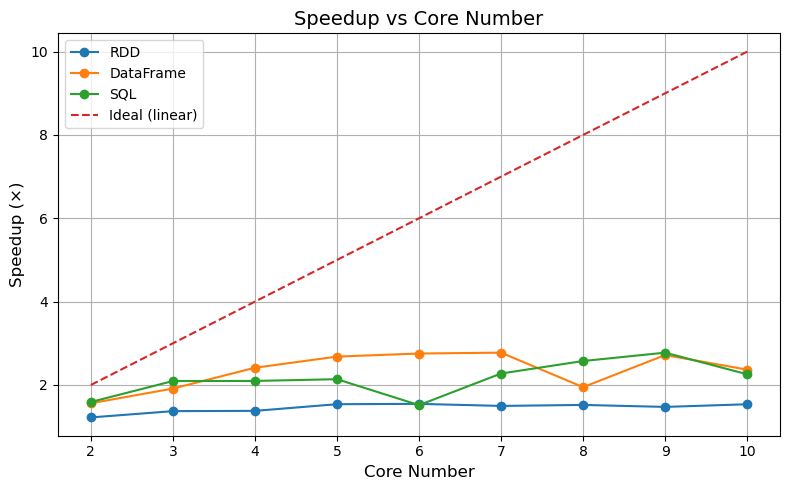

In [45]:
rdd_speedup2 = [times_rdd[0] / t for t in times_rdd[1:]]
dataframe_speedup2 = [times_df[0] / t for t in times_df[1:]]
sql_speedup2 = [times_sql[0] / t for t in times_sql[1:]]


end = len(rdd_speedup2) + 2          
cores = list(range(2, end))         

ideal_speedup = cores[:]             


plt.figure(figsize=(8, 5))
plt.plot(cores, rdd_speedup2, marker='o', label='RDD')
plt.plot(cores, dataframe_speedup2, marker='o', label='DataFrame')
plt.plot(cores, sql_speedup2, marker='o', label='SQL')

plt.plot(cores, ideal_speedup, linestyle='--', label='Ideal (linear)')

plt.title("Speedup vs Core Number", fontsize=14)
plt.xlabel("Core Number", fontsize=12)
plt.ylabel("Speedup (×)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Tips and Fares by Passenger Count

The main goal is to analyze how the number of passengers in a taxi trip influences financial metrics such as tip amounts and total fares.  
To achieve this, we use the following columns from the dataset:

- passenger_count: the number of passengers recorded for the trip (ranging from 1 to 6 based on NYC taxi capacity).  
- tip_amount: the tip given by the passenger, in USD.  
- fare_amount: the base fare charged for the trip, in USD.  

Each trip is grouped by passenger_count, and we compute two aggregate metrics:
- Average tip per passenger count.
- Average total fare (fare_amount + tip_amount) per passenger count.

By analyzing these patterns, we can identify whether larger groups tip proportionally more or if individual contribution decreases as group size increases.

From a computational perspective, this study also evaluates Spark's scalability by measuring the speedup achieved with increasing core counts across the three APIs: DataFrame, RDD, and SQL.

#### General Code

The following helper function visualizes the results as two side-by-side bar charts: one for average tips and another for average total fares.

In [47]:
def plot_results_tips_fares(passenger_counts, avg_tips, avg_fares):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Average Tips
    ax1.bar(passenger_counts, avg_tips, color='goldenrod')
    ax1.set_xlabel('Number of Passengers')
    ax1.set_ylabel('Average Tip Amount ($)')
    ax1.set_title('Average Tip by Passenger Count')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Plot 2: Average Total Fare
    ax2.bar(passenger_counts, avg_fares, color='teal')
    ax2.set_xlabel('Number of Passengers')
    ax2.set_ylabel('Average Total Fare ($)')
    ax2.set_title('Average Total Fare by Passenger Count')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


#### DataFrames


In this section, we use the Spark DataFrame API to compute average tips and total fares by passenger count. The code groups all trips by the `passenger_count` column and applies two aggregate functions to compute the mean of `tip_amount` and `total_fare`. The results are then sorted and collected. This approach leverages Spark's Catalyst optimizer, which automatically generates an optimized execution plan. We expect DataFrame to deliver moderate performance, faster than RDD and SQL due to pandas parallelization optimization.


In [48]:
def calculate_tips_dataframes(df_local):
    dataframe_start = time.time()
    grouped_trips = df_local.groupBy('passenger_count')
    avg_results = grouped_trips.agg(
        F.avg('tip_amount').alias('avg_tip'),
        F.avg(F.col('fare_amount') + F.col('tip_amount')).alias('avg_total_fare')
    )
    top_rows = avg_results.orderBy('passenger_count').collect()
    dataframe_end = time.time()
    dataframe_time = dataframe_end - dataframe_start
    return top_rows, dataframe_time

<SparkContext master=local[1] appName=Dataframe_TipsFares_1_cores>
<SparkContext master=local[2] appName=Dataframe_TipsFares_2_cores>
<SparkContext master=local[3] appName=Dataframe_TipsFares_3_cores>
<SparkContext master=local[4] appName=Dataframe_TipsFares_4_cores>
<SparkContext master=local[5] appName=Dataframe_TipsFares_5_cores>
<SparkContext master=local[6] appName=Dataframe_TipsFares_6_cores>
<SparkContext master=local[7] appName=Dataframe_TipsFares_7_cores>
<SparkContext master=local[8] appName=Dataframe_TipsFares_8_cores>
<SparkContext master=local[9] appName=Dataframe_TipsFares_9_cores>
<SparkContext master=local[10] appName=Dataframe_TipsFares_10_cores>


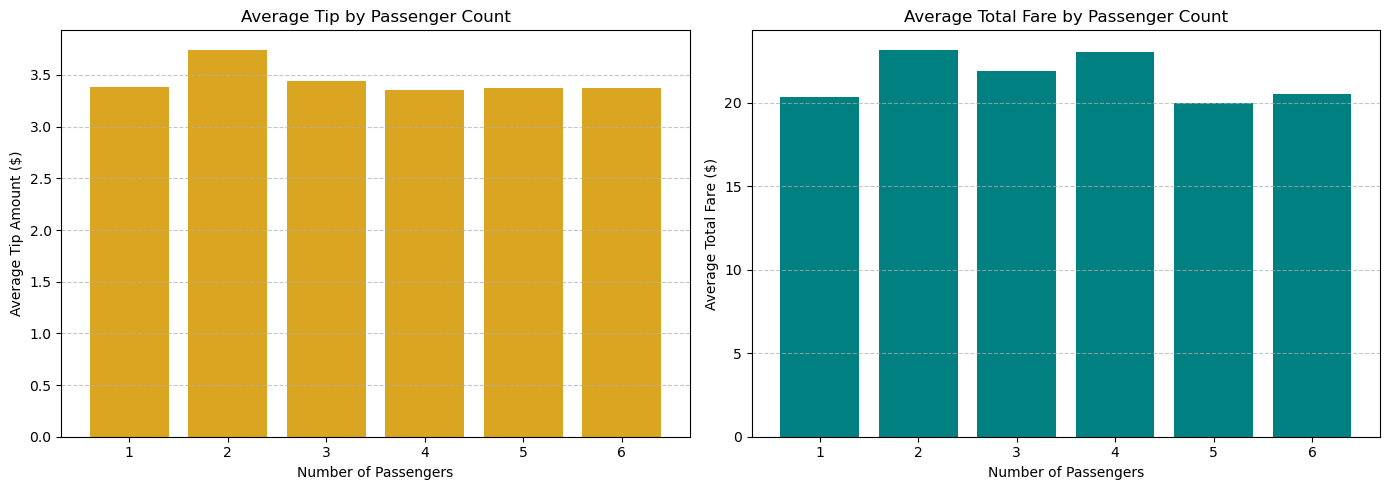


DATAFRAME EXECUTION TIMES
----------------------------------------
Time spent using 1 cores: 2.96 seconds
Time spent using 2 cores: 1.57 seconds
Time spent using 3 cores: 1.12 seconds
Time spent using 4 cores: 1.08 seconds
Time spent using 5 cores: 0.93 seconds
Time spent using 6 cores: 0.88 seconds
Time spent using 7 cores: 0.77 seconds
Time spent using 8 cores: 0.91 seconds
Time spent using 9 cores: 0.85 seconds
Time spent using 10 cores: 1.03 seconds


In [49]:
tipfare_df_times = []

for i in range(1, 11):  # From 1 to 10 to test multiple cores
    delete_spark(spark)
    spark = SparkSession.builder.master(f"local[{i}]").appName(f"Dataframe_TipsFares_{i}_cores").getOrCreate()
    print(spark.sparkContext)
    df = get_df(spark)
    df_local = df.select("passenger_count", "fare_amount", "tip_amount")
    top_rows, dataframe_time = calculate_tips_dataframes(df_local)
    tipfare_df_times.append(dataframe_time)

passenger_counts = [r['passenger_count'] for r in top_rows]
avg_tips = [r['avg_tip'] for r in top_rows]
avg_fares = [r['avg_total_fare'] for r in top_rows]
plot_results_tips_fares(passenger_counts, avg_tips, avg_fares)

print("\nDATAFRAME EXECUTION TIMES")
print("-" * 40)
for idx, cores in enumerate(range(1, 11)):
    print(f"Time spent using {cores} cores: {tipfare_df_times[idx]:.2f} seconds")

#### RDDs

In this section, we implement the same computation using Spark's RDD API through a map-reduce pattern. Each row is first mapped to a key-value pair where the key is `passenger_count` and the value is a tuple containing tip amount, total fare, and a count of 1. These pairs are then reduced by key using `reduceByKey` to sum tips, fares, and counts across all trips with the same passenger count. Finally, we compute averages by dividing the accumulated sums by the trip count. This low-level approach requires manual orchestration of transformations and lacks automatic optimization, making it the slowest of the three methods due to the overhead of converting data between Python and Java for each operation.

In [50]:
def calculate_tips_rdds(df_local):
    rdds_start = time.time()
    rdd = df_local.rdd
    rdd_mapped = rdd.map(lambda x: (x[0], (x[1], x[1] + x[2], 1)))  # (passenger_count, (tip, total_fare, count))
    rdd_reduced = rdd_mapped.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2]))
    rdd_avg = rdd_reduced.mapValues(lambda v: (v[0] / v[2], v[1] / v[2]))  # (avg_tip, avg_total_fare)
    ordered_rdd = rdd_avg.sortByKey().collect()
    rdds_end = time.time()
    rdd_time = rdds_end - rdds_start
    return ordered_rdd, rdd_time


<SparkContext master=local[1] appName=RDD_TipsFares_1_cores>
<SparkContext master=local[2] appName=RDD_TipsFares_2_cores>
<SparkContext master=local[3] appName=RDD_TipsFares_3_cores>
<SparkContext master=local[4] appName=RDD_TipsFares_4_cores>
<SparkContext master=local[5] appName=RDD_TipsFares_5_cores>
<SparkContext master=local[6] appName=RDD_TipsFares_6_cores>
<SparkContext master=local[7] appName=RDD_TipsFares_7_cores>
<SparkContext master=local[8] appName=RDD_TipsFares_8_cores>
<SparkContext master=local[9] appName=RDD_TipsFares_9_cores>
<SparkContext master=local[10] appName=RDD_TipsFares_10_cores>


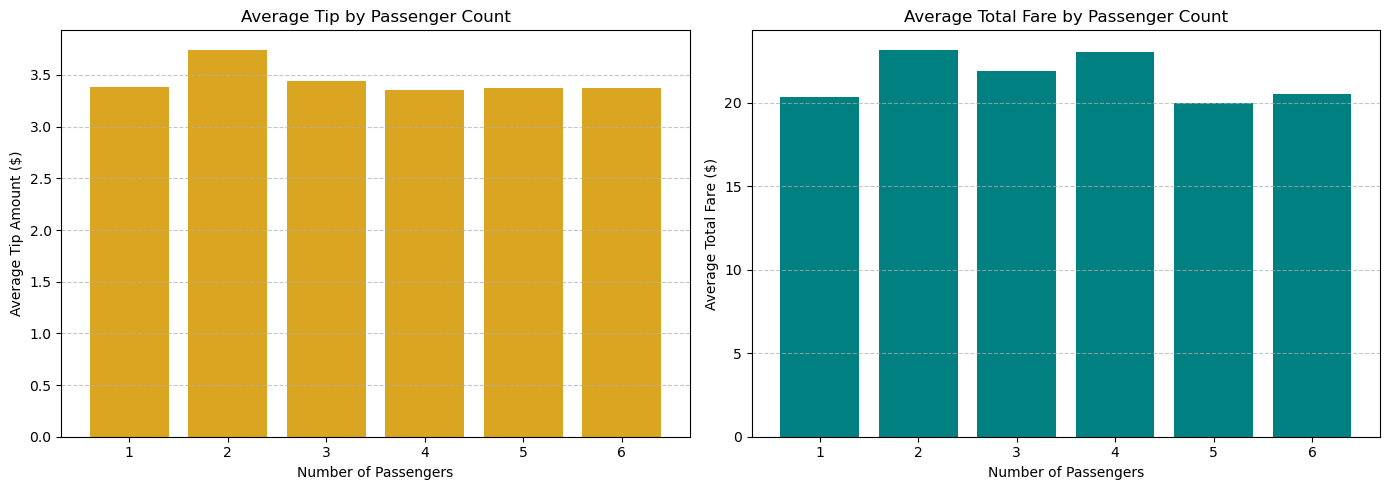


RDD EXECUTION TIMES
----------------------------------------
Time spent using 1 cores: 7.98 seconds
Time spent using 2 cores: 6.55 seconds
Time spent using 3 cores: 5.12 seconds
Time spent using 4 cores: 5.46 seconds
Time spent using 5 cores: 6.01 seconds
Time spent using 6 cores: 5.31 seconds
Time spent using 7 cores: 6.30 seconds
Time spent using 8 cores: 6.37 seconds
Time spent using 9 cores: 5.17 seconds
Time spent using 10 cores: 5.90 seconds


In [51]:
tipfare_rdd_times = []

for i in range(1, 11):  # From 1 to 10 to test multiple cores
    delete_spark(spark)
    spark = SparkSession.builder.master(f"local[{i}]").appName(f"RDD_TipsFares_{i}_cores").getOrCreate()
    print(spark.sparkContext)
    df = get_df(spark)
    df_local = df.select("passenger_count", "tip_amount", "fare_amount")
    top_rows, rdd_time = calculate_tips_rdds(df_local)
    tipfare_rdd_times.append(rdd_time)

passenger_counts = [p for (p, (tip, fare)) in top_rows]
avg_tips = [tip for (p, (tip, fare)) in top_rows]
avg_fares = [fare for (p, (tip, fare)) in top_rows]
plot_results_tips_fares(passenger_counts, avg_tips, avg_fares)

print("\nRDD EXECUTION TIMES")
print("-" * 40)
for idx, cores in enumerate(range(1, 11)):
    print(f"Time spent using {cores} cores: {tipfare_rdd_times[idx]:.2f} seconds")

#### SQL

Using Spark SQL, we create a temporary view and perform aggregation using standard SQL `AVG()` and `GROUP BY` syntax.


Using Spark SQL, we express the entire analysis as a declarative SQL query. After registering the DataFrame as a temporary view, we execute a query that groups trips by `passenger_count` and computes average tip and total fare using the standard SQL `AVG()` function. Spark's SQL engine parses the query, applies optimizations such as predicate pushdown and columnar processing, and produces an efficient execution plan. We expect SQL to be the fastest method, as it benefits from the most aggressive query optimization and can generate optimized bytecode for the entire pipeline.


In [52]:
def calculate_tips_sql(df):
    sql_start = time.time()
    df.createOrReplaceTempView('financial_tips')
    results = spark.sql("""
        SELECT 
            passenger_count,
            AVG(tip_amount) as avg_tip,
            AVG(fare_amount + tip_amount) as avg_total_fare
        FROM financial_tips
        GROUP BY passenger_count
        ORDER BY passenger_count
    """)
    top_rows = results.collect()
    sql_end = time.time()
    sql_time = sql_end - sql_start
    return top_rows, sql_time


<SparkContext master=local[1] appName=SQL_TipsFares_1_cores>
<SparkContext master=local[2] appName=SQL_TipsFares_2_cores>
<SparkContext master=local[3] appName=SQL_TipsFares_3_cores>
<SparkContext master=local[4] appName=SQL_TipsFares_4_cores>
<SparkContext master=local[5] appName=SQL_TipsFares_5_cores>
<SparkContext master=local[6] appName=SQL_TipsFares_6_cores>
<SparkContext master=local[7] appName=SQL_TipsFares_7_cores>
<SparkContext master=local[8] appName=SQL_TipsFares_8_cores>
<SparkContext master=local[9] appName=SQL_TipsFares_9_cores>
<SparkContext master=local[10] appName=SQL_TipsFares_10_cores>


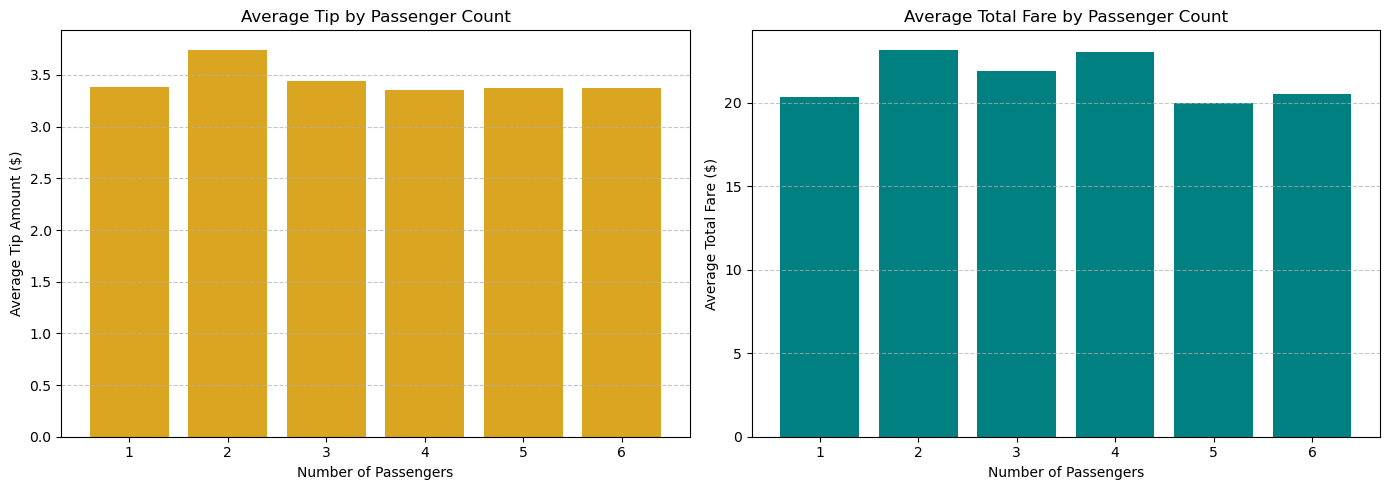


SQL EXECUTION TIMES
----------------------------------------
Time spent using 1 cores: 1.34 seconds
Time spent using 2 cores: 1.02 seconds
Time spent using 3 cores: 0.93 seconds
Time spent using 4 cores: 0.88 seconds
Time spent using 5 cores: 0.80 seconds
Time spent using 6 cores: 0.88 seconds
Time spent using 7 cores: 0.93 seconds
Time spent using 8 cores: 0.86 seconds
Time spent using 9 cores: 0.85 seconds
Time spent using 10 cores: 0.92 seconds


In [53]:
tipfare_sql_times = []

for i in range(1, 11):  # From 1 to 10 to test multiple cores
    delete_spark(spark)
    spark = SparkSession.builder.master(f"local[{i}]").appName(f"SQL_TipsFares_{i}_cores").getOrCreate()
    print(spark.sparkContext)
    df = get_df(spark)
    top_rows, sql_time = calculate_tips_sql(df)
    tipfare_sql_times.append(sql_time)

passenger_counts = [r['passenger_count'] for r in top_rows]
avg_tips = [r['avg_tip'] for r in top_rows]
avg_fares = [r['avg_total_fare'] for r in top_rows]
plot_results_tips_fares(passenger_counts, avg_tips, avg_fares)

print("\nSQL EXECUTION TIMES")
print("-" * 40)
for idx, cores in enumerate(range(1, 11)):
    print(f"Time spent using {cores} cores: {tipfare_sql_times[idx]:.2f} seconds")

#### Speedups

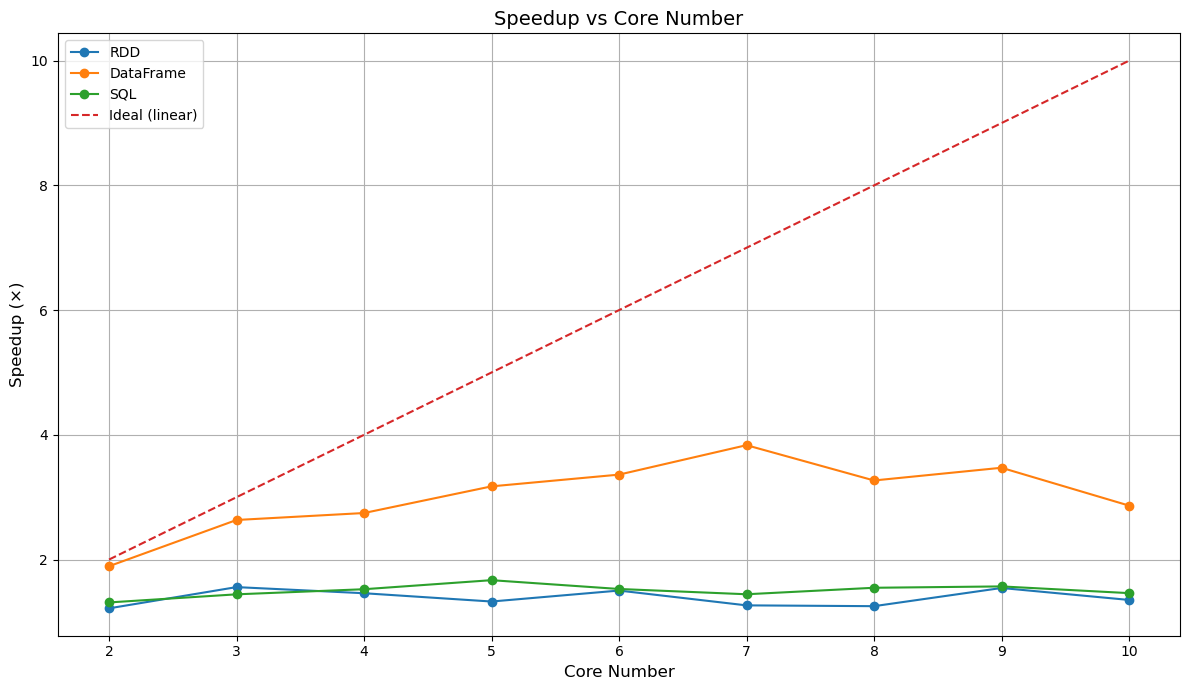

In [54]:
rdd_speedup3 = [tipfare_rdd_times[0] / t for t in tipfare_rdd_times[1:]]
dataframe_speedup3 = [tipfare_df_times[0] / t for t in tipfare_df_times[1:]]
sql_speedup3 = [tipfare_sql_times[0] / t for t in tipfare_sql_times[1:]]

end = len(rdd_speedup3) + 2
cores = list(range(2, end))
ideal_speedup = cores[:]

plt.figure(figsize=(12,7))
plt.plot(cores, rdd_speedup3, marker='o', label='RDD')
plt.plot(cores, dataframe_speedup3, marker='o', label='DataFrame')
plt.plot(cores, sql_speedup3, marker='o', label='SQL')

plt.plot(cores, ideal_speedup, linestyle='--', label='Ideal (linear)')

plt.title("Speedup vs Core Number", fontsize=14)
plt.xlabel("Core Number", fontsize=12)
plt.ylabel("Speedup (×)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

##### Speedup Analysis

The figure above shows the speedup achieved by each API as the number of cores increases, compared to the ideal linear speedup.

Key observations:

- **Limited speedup:** All three APIs show modest speedup (below 4), far below the ideal linear curve.
- **Low cardinality problem:** Unlike the taxi routes analysis (which groups by hundreds of distinct route combinations), this study groups by only 6 distinct values of passenger_count. 
This severely limits Spark's ability to distribute work efficiently across cores.
- **Overhead dominance:** With such a small number of groups, the overhead of Spark (task scheduling, data shuffling, and result collection) dominates over the actual computation, preventing significant speedup.

As expected, SQL shows the best performance overall due to query optimization, but even it struggles to achieve strong scaling on this low-cardinality aggregation.

To conclude, the limited speedup is a direct consequence of the problem's inherent characteristics (low cardinality grouping key) rather than an implementation flaw. This analysis highlights that Spark's parallelism benefits are most pronounced when processing high-cardinality data or computationally intensive operations.


## Taxi-trips

The main goal is to determine the most frequent taxi routes between pickup and drop-off locations in New York City.  
To achieve this, we use the following columns from the dataset:

- PULocationID – the numeric identifier of the zone where the passenger was picked up.  
- DOLocationID – the numeric identifier of the zone where the passenger was dropped off.  

Each pair `(PULocationID, DOLocationID)` represents a single trip from one location to another. By counting how often each pair appears, we can identify the most common taxi routes.

In order to make the results human-readable, we map these numeric identifiers to their corresponding borough and zone names using the official TLC lookup table (`lookup.csv`). 

From a computational point of view, the study also evaluates the scalability of Spark by measuring the speedup achieved with increasing core counts when utilizing the complete Spark API.

### General Code

In [55]:
TOP_N = 15 
LOOKUP_CSV = "taxi_zone_lookup.csv"
ID_TO_NAME = {}

In [56]:
with open(LOOKUP_CSV, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        loc = row["LocationID"].strip()
        borough = row["Borough"].strip()
        zone = row["Zone"].strip()
        ID_TO_NAME[loc] = f"{borough} – {zone}"
route_counts = {}

In [57]:
def plot_results_most_common_trips(labels, values):
    plt.figure(figsize=(12, 6))
    plt.barh(labels, values)
    plt.gca().invert_yaxis()
    plt.xlabel("Amount of trips")
    plt.ylabel("Route (Pickup → Dropoff)")
    plt.title(f"Top {TOP_N} most common taxi trips")
    plt.tight_layout()
    plt.show()

### Dataframes

In this section, we use the Spark DataFrame API to compute the most frequent taxi routes.  

The function below groups the dataset by pickup and drop-off location IDs, counts the number of trips for each route, sorts the results in descending order using `.desc()`, and selects the top `N` most frequent routes with `.limit()`.  
Previous transformations are lazy, therefore the function finnaly uses `.collect()` to trigger the actual computation and retrieve the results to the driver program.

In [58]:
def calculate_max_trips_dataframes (df_local):
    dataframe_start=time.time()
    grouped_trips=df_local.groupBy('PULocationID','DOLocationID')
    counted_trips=grouped_trips.count()
    top_rows=counted_trips.sort(counted_trips['count'].desc()).limit(TOP_N).collect() # Only collect is the action in this case
    dataframe_end=time.time()
    dataframe_time=dataframe_end-dataframe_start
    return top_rows, dataframe_time


<SparkContext master=local[1] appName=Dataframe_TaxiTrips_1_cores>
<SparkContext master=local[2] appName=Dataframe_TaxiTrips_2_cores>
<SparkContext master=local[3] appName=Dataframe_TaxiTrips_3_cores>
<SparkContext master=local[4] appName=Dataframe_TaxiTrips_4_cores>
<SparkContext master=local[5] appName=Dataframe_TaxiTrips_5_cores>
<SparkContext master=local[6] appName=Dataframe_TaxiTrips_6_cores>
<SparkContext master=local[7] appName=Dataframe_TaxiTrips_7_cores>
<SparkContext master=local[8] appName=Dataframe_TaxiTrips_8_cores>
<SparkContext master=local[9] appName=Dataframe_TaxiTrips_9_cores>
<SparkContext master=local[10] appName=Dataframe_TaxiTrips_10_cores>


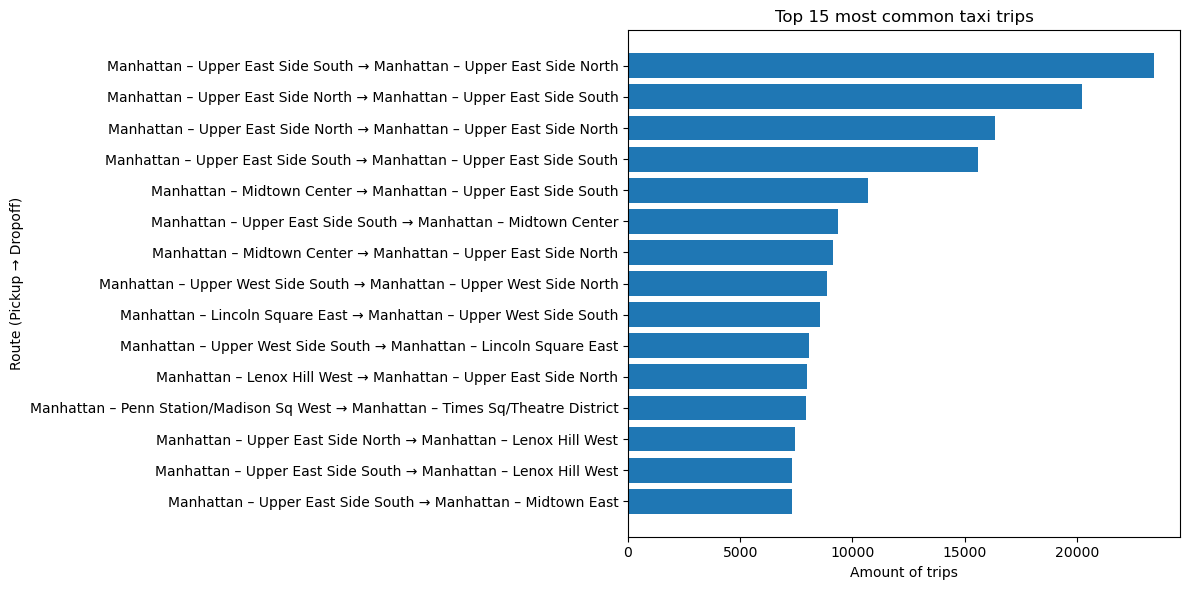

[2.1976640224456787, 1.4496533870697021, 1.328310251235962, 1.062931776046753, 1.1202328205108643, 1.0946264266967773, 1.0557188987731934, 1.1411595344543457, 1.0831434726715088, 1.0927505493164062]


In [59]:
taxi_trips_df_times=[]

for i in range(1,11): # From 1 to 10 to test multiple cores
    delete_spark(spark)
    spark = SparkSession.builder.master(f"local[{i}]").appName(f"Dataframe_TaxiTrips_{i}_cores").getOrCreate()
    print(spark.sparkContext)
    df=get_df(spark)
    df_local=df.select("PULocationID", "DOLocationID")
    top_rows,dataframe_time=calculate_max_trips_dataframes(df_local)
    taxi_trips_df_times.append(dataframe_time)



labels = [f"{ID_TO_NAME.get(str(r['PULocationID']), f'ID {r['PULocationID']}')} → "
          f"{ID_TO_NAME.get(str(r['DOLocationID']), f'ID {r['DOLocationID']}')}"
          for r in top_rows]
values = [r["count"] for r in top_rows]
plot_results_most_common_trips(labels=labels, values=values)
print(taxi_trips_df_times)

### RDDs


In this section, we implement the same computation using Spark’s RDD (Resilient Distributed Dataset) API.  

The function below converts the DataFrame into an RDD and computes the most frequent taxi routes by applying several RDD transformations:

- `.map(lambda x: ((x[0], x[1]), 1))`:  
  Transforms each row into a key–value pair, where the key is the route `(PULocationID, DOLocationID)` and the value is `1`, representing a single trip.

- `.reduceByKey(lambda a, b: a + b)`:  
  Aggregates all trips with the same key (i.e., the same route) by summing their counts.

- `.takeOrdered(TOP_N, lambda x: -x[1])`:  
  Retrieves the top `N` most frequent routes, sorted by descending trip count. The `lambda x: -x[1]` inverts the sign of the count to sort from highest to lowest.

In [60]:
def calculate_max_trips_rdds(df_local):
    rdss_start=time.time()
    rdd=df_local.rdd
    rdd_trips=rdd.map(lambda x:((x[0],x[1]),1)) ## if we'd use faltMap we would get [263,161,1...] instead of [(263,161,1),...()]
    count_trips_rdds=rdd_trips.reduceByKey(lambda a,b:a+b)
    ordered_rdd=count_trips_rdds.takeOrdered(TOP_N,lambda x:-x[1]) #- to descending jeje
    rdds_end=time.time()
    rdd_time=rdds_end-rdss_start
    return ordered_rdd, rdd_time

<SparkContext master=local[1] appName=RDD_TaxiTrips_1_cores>
<SparkContext master=local[2] appName=RDD_TaxiTrips_2_cores>
<SparkContext master=local[3] appName=RDD_TaxiTrips_3_cores>
<SparkContext master=local[4] appName=RDD_TaxiTrips_4_cores>
<SparkContext master=local[5] appName=RDD_TaxiTrips_5_cores>
<SparkContext master=local[6] appName=RDD_TaxiTrips_6_cores>
<SparkContext master=local[7] appName=RDD_TaxiTrips_7_cores>
<SparkContext master=local[8] appName=RDD_TaxiTrips_8_cores>
<SparkContext master=local[9] appName=RDD_TaxiTrips_9_cores>
<SparkContext master=local[10] appName=RDD_TaxiTrips_10_cores>


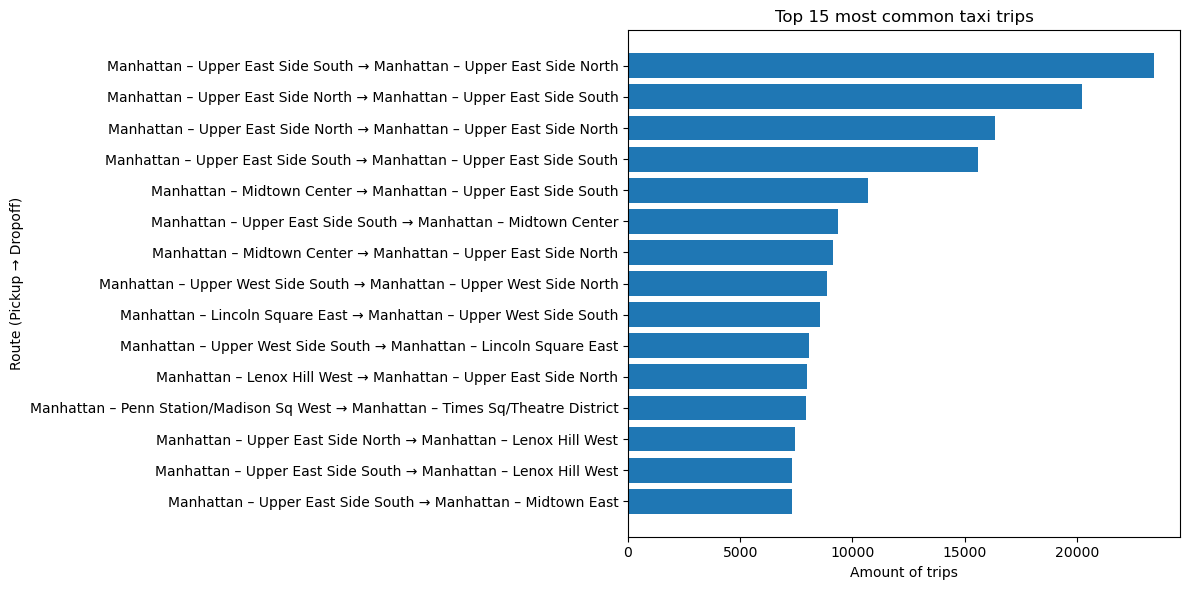

[7.204374074935913, 6.185328960418701, 5.0185465812683105, 5.299007892608643, 6.451267242431641, 6.04102349281311, 7.718419313430786, 5.974549770355225, 5.890637636184692, 5.839479923248291]


In [61]:
taxi_trips_rdd_times=[]

for i in range(1,11): # From 1 to 10 to test multiple cores
    delete_spark(spark)
    spark = SparkSession.builder.master(f"local[{i}]").appName(f"RDD_TaxiTrips_{i}_cores").getOrCreate()
    print(spark.sparkContext)
    df=get_df(spark)
    df_local=df.select("PULocationID", "DOLocationID")
    top_rows,rdd_time=calculate_max_trips_rdds(df_local)
    taxi_trips_rdd_times.append(rdd_time)



labels = [
    f"{ID_TO_NAME.get(str(pu), f'ID {pu}')} → {ID_TO_NAME.get(str(do), f'ID {do}')}"
    for ((pu, do), count) in top_rows
]

values = [count for ((pu, do), count) in top_rows]
plot_results_most_common_trips(labels=labels, values=values)
print(taxi_trips_rdd_times)

### SQL

In this final implementation, we perform the same analysis using Spark SQL, which allows us to express queries in a declarative SQL syntax rather than using functional transformations.  

The function below creates a temporary SQL view from the existing DataFrame and runs a SQL query to identify the most frequent taxi routes.

- `createOrReplaceTempView('taxis')`:  
  Registers the current DataFrame as a temporary SQL table named `'taxis'`. This allows us to run standard SQL queries directly on the DataFrame using `spark.sql()`.

- `spark.sql(""" ... """)`:  
  Executes a SQL query that:
  1. Selects the pickup and drop-off location IDs (`PULocationID`, `DOLocationID`).  
  2. Counts how many trips occur for each unique route using `count('x')`.  
  3. Groups the results by both location IDs.  
  4. Sorts the results in descending order by the count (`order by count('x') desc`).  
  5. Returns only the top N most frequent routes using the `limit` clause.

- `.collect()`:   
  Like in the DataFrame API, all operations before `.collect()` are lazily evaluated, therefore we use it to retrieve the information.

In [62]:
def calculate_max_trips_sql (df):
    sql_start=time.time()
    df.createOrReplaceTempView('taxis')
    results = spark.sql(f"""
            SELECT PULocationID,DOLocationID,count('x') 
                        FROM taxis
                        group by PULocationID,DOLocationID
                        order by count('x') desc
                        limit {TOP_N}
    """)
    top_rows=results.collect()
    sql_end=time.time()
    sql_time=sql_end-sql_start
    return top_rows, sql_time

<SparkContext master=local[1] appName=SQL_TaxiTrips_1_cores>
<SparkContext master=local[2] appName=SQL_TaxiTrips_2_cores>
<SparkContext master=local[3] appName=SQL_TaxiTrips_3_cores>
<SparkContext master=local[4] appName=SQL_TaxiTrips_4_cores>
<SparkContext master=local[5] appName=SQL_TaxiTrips_5_cores>
<SparkContext master=local[6] appName=SQL_TaxiTrips_6_cores>
<SparkContext master=local[7] appName=SQL_TaxiTrips_7_cores>
<SparkContext master=local[8] appName=SQL_TaxiTrips_8_cores>
<SparkContext master=local[9] appName=SQL_TaxiTrips_9_cores>
<SparkContext master=local[10] appName=SQL_TaxiTrips_10_cores>


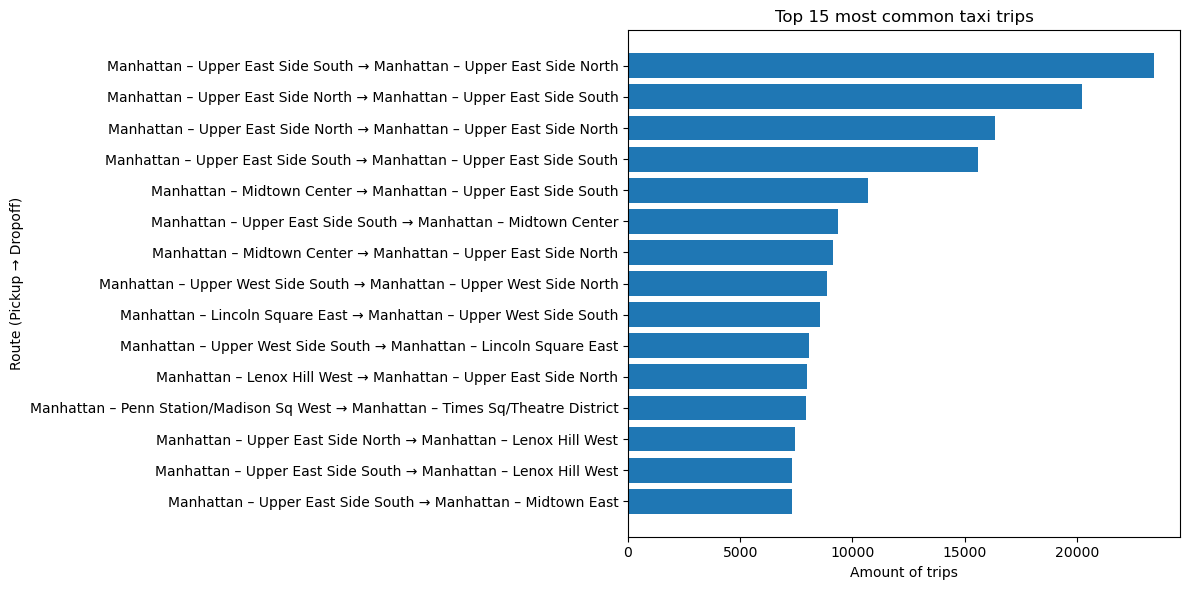

[1.3630828857421875, 1.2753090858459473, 1.036191701889038, 1.000441074371338, 1.0052106380462646, 0.9716348648071289, 1.0597176551818848, 1.0512151718139648, 1.0375542640686035, 1.1325502395629883]


In [63]:

taxi_trips_sql_times=[]

for i in range(1,11): # From 1 to 10 to test multiple cores
    delete_spark(spark)
    spark = SparkSession.builder.master(f"local[{i}]").appName(f"SQL_TaxiTrips_{i}_cores").getOrCreate()
    print(spark.sparkContext)
    df=get_df(spark)
    top_rows,sql_time=calculate_max_trips_sql(df)
    taxi_trips_sql_times.append(sql_time)



labels = [f"{ID_TO_NAME.get(str(r['PULocationID']), f'ID {r['PULocationID']}')} → "
          f"{ID_TO_NAME.get(str(r['DOLocationID']), f'ID {r['DOLocationID']}')}"
          for r in top_rows]
values = [r["count(x)"] for r in top_rows]
plot_results_most_common_trips(labels=labels, values=values)
print(taxi_trips_sql_times)

### Analytical Insight

The figures above displays the Top 15 most common taxi routes in New York City, based on the number of recorded trips in the dataset.  
All the most frequent routes are located within the borough of Manhattan, which is normal because Manhattan concentrates most of the city’s commercial, business, and touristic activity.

Several key observations can be made:

- Every route in the top 15 begins and ends within Manhattan.


- Many of the most common routes occur between neighborhoods with the word *Upper*. These areas combine high residential density with major business and entertainment districts, explaining their strong taxi usage.

- The recurrence of routes between zones that are geographically close (e.g., *Upper East Side North ↔ Upper East Side South*) suggests that taxis are often used for short trips rather than long-distance journeys.

The analysis confirms that Manhattan dominates taxi activity within New York City, with frequent, short, and localized trips between neighboring high-demand areas. 


### Computational Insights

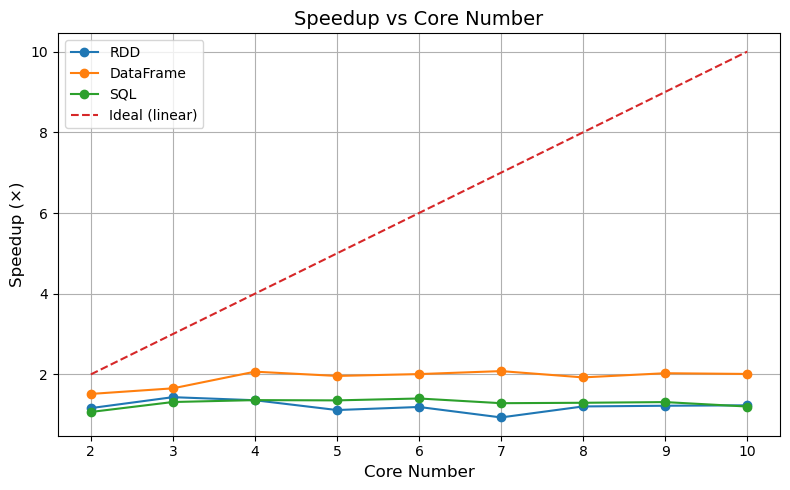

In [64]:
rdd_speedup4 = [taxi_trips_rdd_times[0] / t for t in taxi_trips_rdd_times[1:]]
dataframe_speedup4 = [taxi_trips_df_times[0] / t for t in taxi_trips_df_times[1:]]
sql_speedup4 = [taxi_trips_sql_times[0] / t for t in taxi_trips_sql_times[1:]]


end = len(rdd_speedup4) + 2          
cores = list(range(2, end))         

ideal_speedup = cores[:]             


plt.figure(figsize=(8, 5))
plt.plot(cores, rdd_speedup4, marker='o', label='RDD')
plt.plot(cores, dataframe_speedup4, marker='o', label='DataFrame')
plt.plot(cores, sql_speedup4, marker='o', label='SQL')

plt.plot(cores, ideal_speedup, linestyle='--', label='Ideal (linear)')

plt.title("Speedup vs Core Number", fontsize=14)
plt.xlabel("Core Number", fontsize=12)
plt.ylabel("Speedup (×)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Conclusions on Speedup Performance

Below are the figures corresponding to the speedup obtained for the different implementations (RDD, DataFrame, and SQL). These graphs allow us to analyze performance behavior as the number of CPU cores used increases, with the goal of observing how each approach scales and making some comparative comments on their efficiency and parallelization trends.


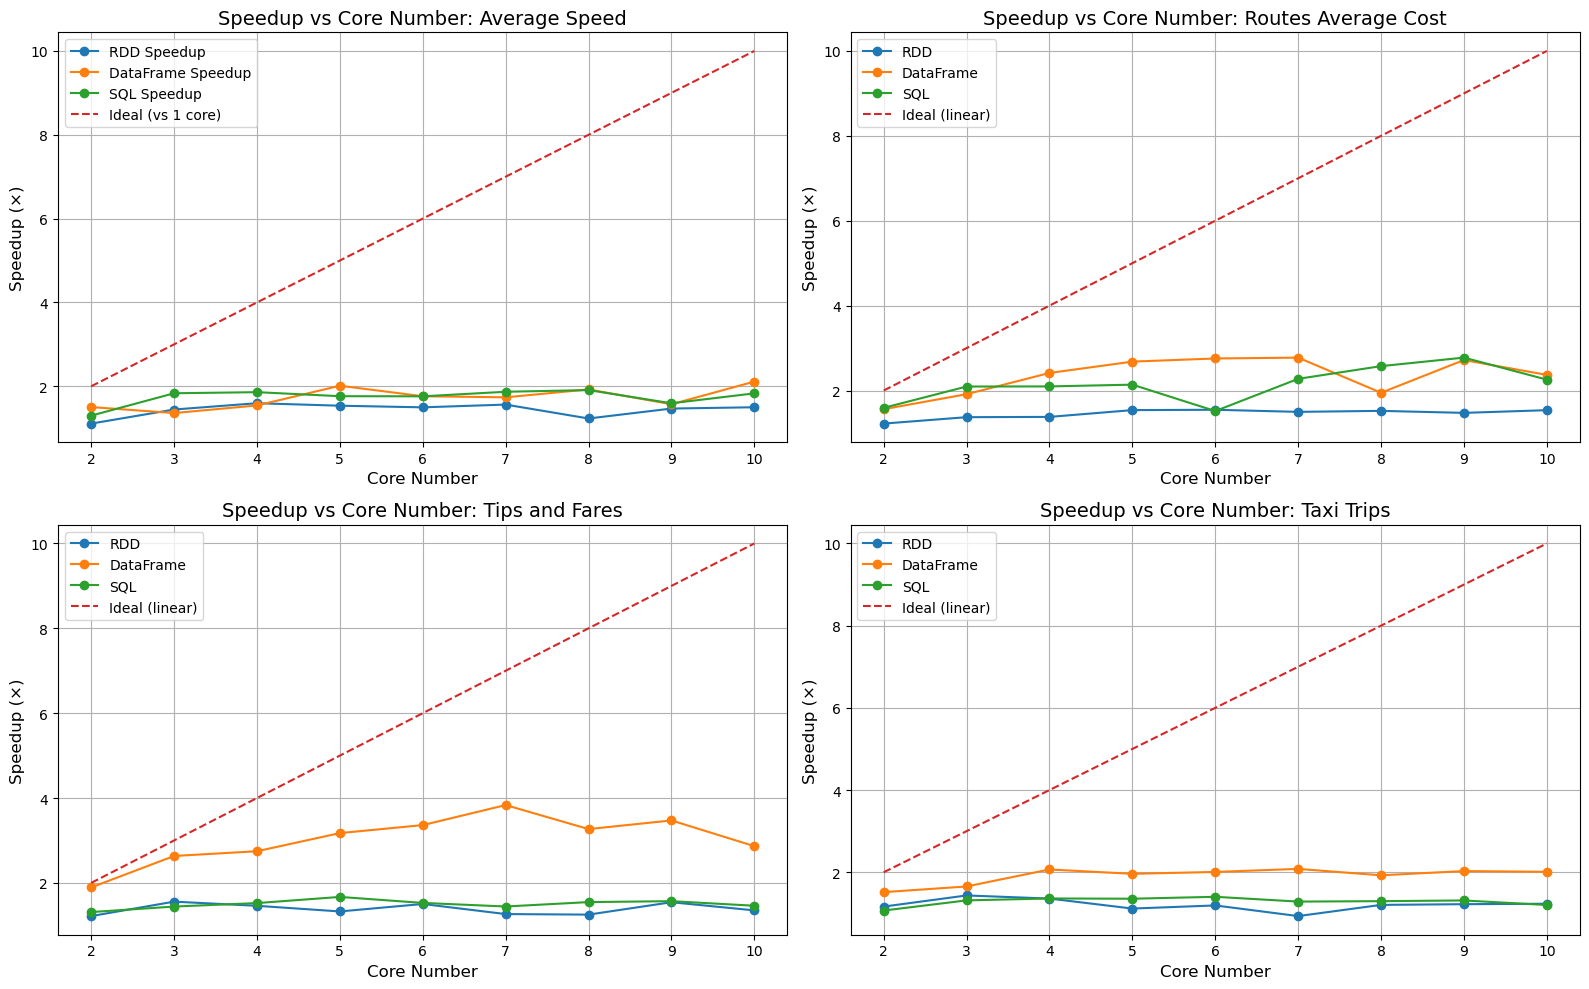

In [66]:
import matplotlib.pyplot as plt

cores = list(range(2, 11))         
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1 (arriba izquierda)
axes[0, 0].plot(cores, rdd_speedup1, marker='o', label='RDD Speedup')
axes[0, 0].plot(cores, dataframe_speedup1, marker='o', label='DataFrame Speedup')
axes[0, 0].plot(cores, sql_speedup1, marker='o', label='SQL Speedup')
axes[0, 0].plot(cores, ideal_speedup, linestyle='--', label=f'Ideal (vs {baseline_core_count} core)')
axes[0, 0].set_title("Speedup vs Core Number: Average Speed", fontsize=14)
axes[0, 0].set_xlabel("Core Number", fontsize=12)
axes[0, 0].set_ylabel("Speedup (×)", fontsize=12)
axes[0, 0].grid(True)
axes[0, 0].legend()

# Plot 2 (arriba derecha)
axes[0, 1].plot(cores, rdd_speedup2, marker='o', label='RDD')
axes[0, 1].plot(cores, dataframe_speedup2, marker='o', label='DataFrame')
axes[0, 1].plot(cores, sql_speedup2, marker='o', label='SQL')
axes[0, 1].plot(cores, ideal_speedup, linestyle='--', label='Ideal (linear)')
axes[0, 1].set_title("Speedup vs Core Number: Routes Average Cost", fontsize=14)
axes[0, 1].set_xlabel("Core Number", fontsize=12)
axes[0, 1].set_ylabel("Speedup (×)", fontsize=12)
axes[0, 1].grid(True)
axes[0, 1].legend()

# Plot 3 (abajo izquierda) 
axes[1, 0].plot(cores, rdd_speedup3, marker='o', label='RDD')
axes[1, 0].plot(cores, dataframe_speedup3, marker='o', label='DataFrame')
axes[1, 0].plot(cores, sql_speedup3, marker='o', label='SQL')
axes[1, 0].plot(cores, ideal_speedup, linestyle='--', label='Ideal (linear)')
axes[1, 0].set_title("Speedup vs Core Number: Tips and Fares", fontsize=14)
axes[1, 0].set_xlabel("Core Number", fontsize=12)
axes[1, 0].set_ylabel("Speedup (×)", fontsize=12)
axes[1, 0].grid(True)
axes[1, 0].legend()

# Plot 4 (abajo derecha)
axes[1, 1].plot(cores, rdd_speedup4, marker='o', label='RDD')
axes[1, 1].plot(cores, dataframe_speedup4, marker='o', label='DataFrame')
axes[1, 1].plot(cores, sql_speedup4, marker='o', label='SQL')
axes[1, 1].plot(cores, ideal_speedup, linestyle='--', label='Ideal (linear)')
axes[1, 1].set_title("Speedup vs Core Number: Taxi Trips", fontsize=14)
axes[1, 1].set_xlabel("Core Number", fontsize=12)
axes[1, 1].set_ylabel("Speedup (×)", fontsize=12)
axes[1, 1].grid(True)
axes[1, 1].legend()

plt.tight_layout()
plt.show()


The figures above shows the speedup achieved by the RDD, DataFrame, and SQL implementations as the number of CPU cores increases, compared to the ideal speedup.

The linear represents the theoretical case in which the workload scales perfectly with the number of cores. In contrast, all three Spark implementations (RDD, DataFrame, and SQL) exhibit a much lower speedup, remaining below ×4 even when using up to 10 cores. Among the three, the DataFrame API achieves a higher speedup, followed by SQL and then RDD, which shows the slowest scaling in general terms.

This behavior can be explained by several factors:

1. **Dataset size**: The dataset used in this experiment is relatively small (less than 64 MB), which limits the benefits of parallel execution. Most of the runtime is dominated by Spark’s initialization, scheduling, and data shuffling overheads rather than by computation itself.

2. **Task scheduling overhead**: As the number of cores increases, the cost of task coordination and context switching coul be limiting potential parallel gains.

3. **Limited parallelizable workload** : Some operations (e.g., joins, aggregations, or shuffles) are not fully parallelizable, particularly for smaller datasets. Therefore, adding more cores does not linearly reduce computation time.

It is worth mentioning that the more computing operations are required, the more the DataFrame API tends to improve its performance compared with the other implementations. This is because the available cores can be better leveraged as the coordination overhead becomes amortized over a larger amount of computation.